In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression


In [2]:
raw_acs=pd.read_csv("..\\..\\Downloads\\Spring_Invitational_2024_data\\Datathon Data\\acs_5yr_est_selected_economic_characteristics_2010-2022.csv")
raw_acs['header']=''

In [3]:
raw_acs

,Label (Grouping),Category,State,Estimate,Margin of Error,Percent,Percent Margin of Error,Year,header
0,EMPLOYMENT STATUS,Header,Alabama,NaN,NaN,NaN,NaN,2010,
1,Population 16 years and over,EMPLOYMENT STATUS,Alabama,"3,714,504","±1,588","3,714,504",(X),2010,
2,In labor force,EMPLOYMENT STATUS,Alabama,"2,246,848","±5,576",60.5%,±0.1,2010,
3,Civilian labor force,EMPLOYMENT STATUS,Alabama,"2,230,879","±5,531",60.1%,±0.1,2010,
4,Employed,EMPLOYMENT STATUS,Alabama,"2,036,867","±5,904",54.8%,±0.2,2010,
...,...,...,...,...,...,...,...,...,...
98015,18 years and over,PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME...,Puerto Rico,(X),(X),39.7%,±0.4,2021,
98016,18 to 64 years,PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME...,Puerto Rico,(X),(X),40.1%,±0.4,2021,
98017,65 years and over,PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME...,Puerto Rico,(X),(X),38.5%,±0.5,2021,
98018,People in families,PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME...,Puerto Rico,(X),(X),40.0%,±0.4,2021,


In [4]:
#gross cell, worst practices, bad code to clean bad data
header_list=[]
replaced_count=0
econ_count=0
for i in tqdm(range(raw_acs.shape[0])):
    #see if the label has an indendentation indicating its a sub level
    if '\xa0' not in raw_acs.iloc[i,0]:
        header_list=[raw_acs.iloc[i,0]]
        #if it doesn't keep the level to use as the top level header
    else:
        #4 tabs per sublevel
        subheader_level=raw_acs.iloc[i,0].count(u'\xa0')//4
        #get all of the appropriate subheaders and put them in the header column for that row
        raw_acs.iloc[i,8]='_'.join(header_list[0:subheader_level])
        #update the headerlist incase this level has a subheader
        header_list=header_list[:]+[raw_acs.iloc[i,0].replace(u'\xa0', u'')]
        
    #see if we are missing a percent but have an estimate for numeric quantities that aren't population estimates

    if raw_acs.iloc[i,5]=='(X)' :
        raw_acs.iloc[i,5]=raw_acs.iloc[i,3]
        replaced_count+=1
    
    #each year income number as reported as year 20XY adjusted dollars, so to fix this we are gonna lump all together and deal with inflation later lol
    if 'IN 20' in raw_acs.iloc[i,1]:
        raw_acs.iloc[i,1]='INCOME AND BENEFITS (Not inflation Adjusted)'
        if 'Total households' in raw_acs.iloc[i,0] or  'Families' in raw_acs.iloc[i,0]:
            econ_count+=1
            raw_acs.iloc[i+1:i+11,8]='by '+raw_acs.iloc[i,0].replace(u'\xa0', u'')
    #sometimes the income in YEAR Dollars gets stuck in the header section and we dont want that 
    if 'IN 20' in  raw_acs.iloc[i,8]:
        raw_acs.iloc[i,8]=''
econ_count

100%|██████████| 98020/98020 [00:28<00:00, 3417.11it/s]


1352

In [5]:
acs=raw_acs
print(acs.shape[0])
#get rid of missing values
acs.replace(to_replace='(X)',value=np.nan,inplace=True)
#drop useless rows
acs=acs[acs['Category']!='Header']
acs['header']=pd.Series.str(acs['header']).replace("$200,000 or more", u'')
#combine the headers to ensure unique column names
acs['Label (Grouping)']=pd.Series.str(acs['Label (Grouping)']).replace(u'\xa0', u'')
acs.loc[:,'full_label']=acs['Category']+'_'+acs['header']+'_'+acs['Label (Grouping)']
#only get the columns we need
acs=acs.iloc[:,[2,3,5,7,9]]
acs=acs.dropna()
print(acs.shape[0])
acs

C:\Users\Jacob\AppData\Local\Temp\ipykernel_37016\324354553.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acs['header']=pd.Series.str(acs['header']).replace("$200,000 or more", u'')
C:\Users\Jacob\AppData\Local\Temp\ipykernel_37016\324354553.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acs['Label (Grouping)']=pd.Series.str(acs['Label (Grouping)']).replace(u'\xa0', u'')
C:\Users\Jacob\AppData\Local\Temp\ipykernel_37016\324354553.py:10: SettingWithCopyWarning: 
A value is trying to be set on a co

98020
76596


,State,Estimate,Percent,Year,full_label
1,Alabama,"3,714,504","3,714,504",2010,EMPLOYMENT STATUS__Population 16 years and over
2,Alabama,"2,246,848",60.5%,2010,EMPLOYMENT STATUS_Population 16 years and over...
3,Alabama,"2,230,879",60.1%,2010,EMPLOYMENT STATUS_Population 16 years and over...
4,Alabama,"2,036,867",54.8%,2010,EMPLOYMENT STATUS_Population 16 years and over...
5,Alabama,"194,012",5.2%,2010,EMPLOYMENT STATUS_Population 16 years and over...
...,...,...,...,...,...
97995,Puerto Rico,"772,116","772,116",2021,HEALTH INSURANCE COVERAGE_Civilian noninstitut...
97996,Puerto Rico,"713,557",92.4%,2021,HEALTH INSURANCE COVERAGE_Civilian noninstitut...
97997,Puerto Rico,"206,789",26.8%,2021,HEALTH INSURANCE COVERAGE_Civilian noninstitut...
97998,Puerto Rico,"535,314",69.3%,2021,HEALTH INSURANCE COVERAGE_Civilian noninstitut...


In [6]:
acs_by_state={state:acs[acs['State']==state] for state in set(acs['State'])}


In [7]:
acs.shape[0]==acs.dropna().shape[0]

True

In [8]:
al=acs_by_state['Alabama']
al[al['Year']==2010].to_csv('test al data.csv')

In [9]:
oil_data_by_state=pd.read_csv('..\\..\\Downloads\\cleaned_production_by_state.csv',index_col=['Date'])
oil_data_by_state=oil_data_by_state.iloc[:,1:]

In [10]:
len(set(acs['full_label'])),set(acs['full_label'])

(186,
 {'CLASS OF WORKER_Civilian employed population 16 years and over_Government workers',
  'CLASS OF WORKER_Civilian employed population 16 years and over_Private wage and salary workers',
  'CLASS OF WORKER_Civilian employed population 16 years and over_Private wage and salary workers_Government workers',
  'CLASS OF WORKER_Civilian employed population 16 years and over_Private wage and salary workers_Self-employed in own not incorporated business workers',
  'CLASS OF WORKER_Civilian employed population 16 years and over_Private wage and salary workers_Unpaid family workers',
  'CLASS OF WORKER_Civilian employed population 16 years and over_Self-employed in own not incorporated business workers',
  'CLASS OF WORKER_Civilian employed population 16 years and over_Unpaid family workers',
  'CLASS OF WORKER__Civilian employed population 16 years and over',
  'COMMUTING TO WORK_Workers 16 years and over_Car, truck, or van -- carpooled',
  'COMMUTING TO WORK_Workers 16 years and over_C

In [11]:
#make it not ugly 
acs_by_col=pd.DataFrame(index=[state+'_'+str(year) for state in acs['State'].unique() for year in range(2010,2023)],columns=['State','Year','YOY_Change_in_Median_household_income','daily_barrels_of_oil per working population']+list(acs['full_label'].unique()))
for state in tqdm(acs['State'].unique()):
    for year in range(2010,2023):
        state_data=acs_by_state[state][acs_by_state[state]['Year']==year]
        acs_by_col.loc[state+'_'+str(year),'State']=state
        acs_by_col.loc[state+'_'+str(year),'Year']=year
        for col in state_data['full_label'].unique():
            acs_by_col.loc[state+'_'+str(year),col]=state_data[state_data['full_label']==col]['Percent'].values

#make a couple columns we are going to use into integers - the commas in the data make the values strings and pandas cant coerce them into integers for some god forsaken reason            
acs_by_col["INCOME AND BENEFITS (Not inflation Adjusted)__Median household income (dollars)"]=[int(str(i).replace(u',', u'')) for i in acs_by_col["INCOME AND BENEFITS (Not inflation Adjusted)__Median household income (dollars)"].values]
acs_by_col['EMPLOYMENT STATUS__Population 16 years and over']=[int(str(i).replace(u',', u'')) for i in acs_by_col["EMPLOYMENT STATUS_Population 16 years and over_Civilian labor force"].values]

100%|██████████| 52/52 [00:22<00:00,  2.32it/s]


In [12]:
for state in tqdm(acs['State'].unique()):
    for year in range(2010,2023):
        if year!=2010:
            #get changes in YOY income
            curr_med_income=acs_by_col.loc[state+'_'+str(year),"INCOME AND BENEFITS (Not inflation Adjusted)__Median household income (dollars)"]
            prev_med_income=acs_by_col.loc[state+'_'+str(year-1),"INCOME AND BENEFITS (Not inflation Adjusted)__Median household income (dollars)"]
            acs_by_col.loc[state+'_'+str(year),'YOY_Change_in_Median_household_income']=(curr_med_income-prev_med_income)/prev_med_income
            #make an oil/person comparison
            if state in oil_data_by_state.columns:
                acs_by_col.loc[state+'_'+str(year),'daily_barrels_of_oil per working population']=oil_data_by_state.loc[year,state]*1000/acs_by_col.loc[state+'_'+str(year),'EMPLOYMENT STATUS__Population 16 years and over']
            else:
                #some states make no oil! Downright unAmerican!
                acs_by_col.loc[state+'_'+str(year),'daily_barrels_of_oil per working population']=0

100%|██████████| 52/52 [00:00<00:00, 358.62it/s]


In [13]:
#isn't it beautiful 
acs_by_col.to_csv('acs_better_formating.csv')
acs_by_col

,State,Year,YOY_Change_in_Median_household_income,daily_barrels_of_oil per working population,EMPLOYMENT STATUS__Population 16 years and over,EMPLOYMENT STATUS_Population 16 years and over_In labor force,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force_Employed,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force_Unemployed,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Armed Forces,...,HEALTH INSURANCE COVERAGE_Civilian noninstitutionalized population 19 to 64 years_In labor force:_Employed:_With health insurance coverage_With private health insurance,HEALTH INSURANCE COVERAGE_Civilian noninstitutionalized population 19 to 64 years_In labor force:_Employed:_With health insurance coverage_With private health insurance_With public coverage,HEALTH INSURANCE COVERAGE_Civilian noninstitutionalized population 19 to 64 years_In labor force:_Employed:_With health insurance coverage_No health insurance coverage,HEALTH INSURANCE COVERAGE_Civilian noninstitutionalized population 19 to 64 years_In labor force:_Employed:_Unemployed:,HEALTH INSURANCE COVERAGE_Civilian noninstitutionalized population 19 to 64 years_In labor force:_Employed:_With health insurance coverage_With health insurance coverage,HEALTH INSURANCE COVERAGE_Civilian noninstitutionalized population 19 to 64 years_In labor force:_Employed:_With health insurance coverage_With private health insurance_With private health insurance,HEALTH INSURANCE COVERAGE_Civilian noninstitutionalized population 19 to 64 years_In labor force:_Not in labor force:,HEALTH INSURANCE COVERAGE_Civilian noninstitutionalized population 19 to 64 years_In labor force:_Employed:_With health insurance coverage_With public coverage,HEALTH INSURANCE COVERAGE_Civilian noninstitutionalized population 19 to 64 years_In labor force:_Employed:_No health insurance coverage,"COMMUTING TO WORK_Workers 16 years and over_Car, truck, or van -- drove alone_Worked from home"
Alabama_2010,Alabama,2010,NaN,NaN,2230879,60.5%,60.1%,54.8%,5.2%,0.4%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alabama_2011,Alabama,2011,0.02027,3.732178,2243462,60.3%,59.8%,54.1%,5.7%,0.4%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alabama_2012,Alabama,2012,0.005264,4.235847,2248665,59.9%,59.5%,53.4%,6.1%,0.4%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alabama_2013,Alabama,2013,0.002155,4.637954,2244093,59.4%,59.0%,52.6%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alabama_2014,Alabama,2014,0.005965,4.390468,2239169,58.8%,58.5%,52.5%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Puerto Rico_2018,Puerto Rico,2018,0.019772,0,1238450,44.4%,44.3%,36.8%,NaN,NaN,...,"[61.6%, 26.8%]","[29.8%, 71.1%]","[10.6%, 12.7%]","198,555",87.3%,17.3%,"809,968",70.6%,6.5%,NaN
Puerto Rico_2019,Puerto Rico,2019,0.018496,0,1225447,44.5%,44.4%,37.3%,NaN,NaN,...,"[61.1%, 26.5%]","[29.6%, 69.9%]","[11.1%, 13.8%]","186,849",86.2%,17.4%,"782,851",70.5%,6.9%,2.3%
Puerto Rico_2020,Puerto Rico,2020,0.025269,0,1208551,44.4%,44.3%,37.6%,NaN,NaN,...,"[60.8%, 26.8%]","[29.4%, 69.1%]","[11.5%, 14.5%]","173,231",85.5%,17.6%,"764,101",69.7%,7.3%,3.1%
Puerto Rico_2021,Puerto Rico,2021,0.043166,0,1236011,44.3%,44.2%,37.7%,NaN,NaN,...,"[60.1%, 26.8%]","[30.1%, 68.4%]","[11.4%, 14.3%]","171,430",85.7%,18.5%,"772,116",69.3%,7.6%,4.2%


In [14]:
states=list(set(acs_by_col['State']))
states.remove('Puerto Rico')
states.sort()
states
state_abbreviations = { "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "District of Columbia": "DC", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY" }
col="INCOME AND BENEFITS (Not inflation Adjusted)__Median household income (dollars)"
avg_state_median_income_by_year=np.array([ acs_by_col[(acs_by_col['Year']==year)][col].mean() for year in range(2010,2023)])
avg_state_median_income_by_year_YOY=[(avg_state_median_income_by_year[i]-avg_state_median_income_by_year[i-1])/avg_state_median_income_by_year[i-1] for i in range(1,len(avg_state_median_income_by_year))]
avg_state_median_income_by_year

array([51142.05769231, 52282.84615385, 52672.90384615, 52878.23076923,
       53468.78846154, 53957.51923077, 55330.57692308, 57496.82692308,
       59842.69230769, 62279.42307692, 64199.26923077, 67969.76923077,
       73828.05769231])

In [15]:
commods=pd.read_csv("..\\..\\Downloads\\Spring_Invitational_2024_data\\Datathon Data\\all_commodities.csv")
commods.loc[:,'Date_Time']=pd.to_datetime(commods.loc[:,'Date_Time'])
commods=commods.dropna()

wti=commods[commods['Commodity']=='West Texas Intermediary Crude Oil']
wti_avg_by_year=[ wti[ wti['Date_Time'].between(pd.Timestamp(year=year,month=1,day=1),pd.Timestamp(year=year+1,month=1,day=1))]['Value'].mean() for year in range(2010,2023)]
wti_avg_by_year


[79.47571428571429,
 94.88087301587301,
 94.05333333333334,
 97.98253968253968,
 93.17222222222223,
 48.656706349206345,
 43.293650793650784,
 50.800320000000006,
 65.22746987951807,
 56.98832,
 39.16043650793651,
 68.13509960159362,
 94.90286852589641]

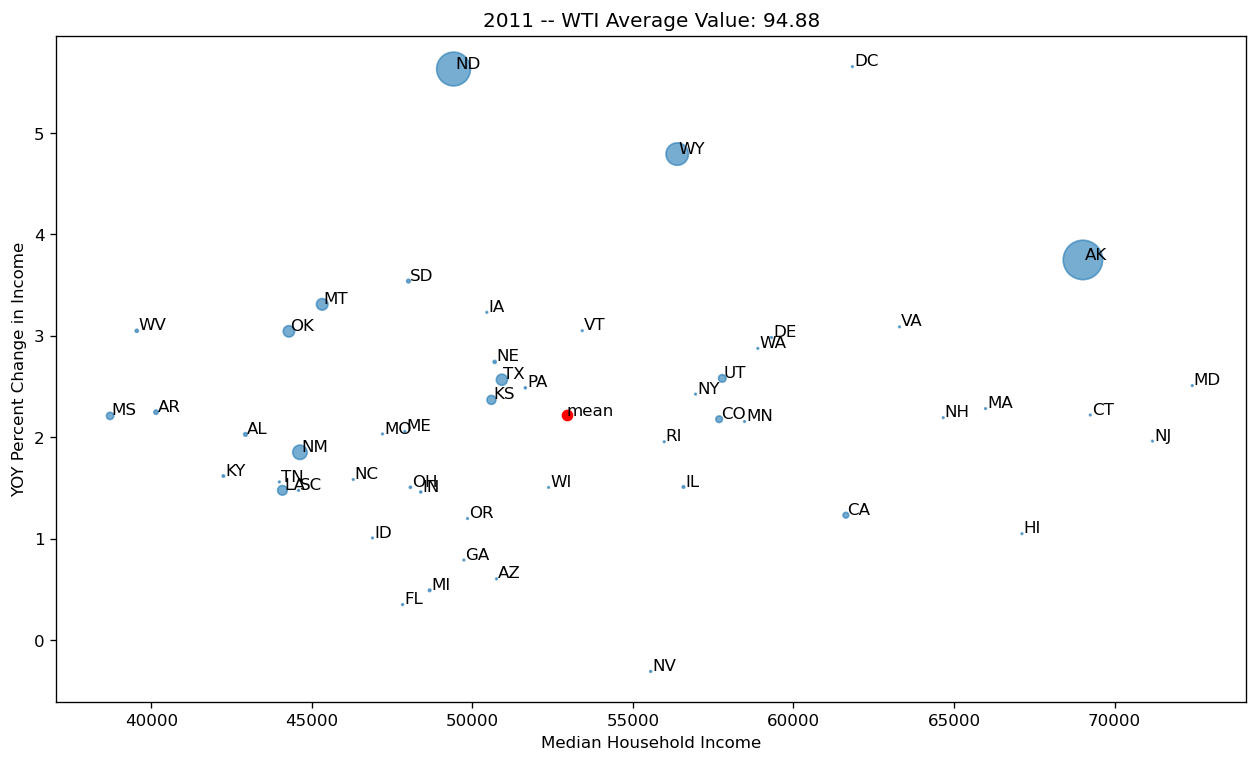

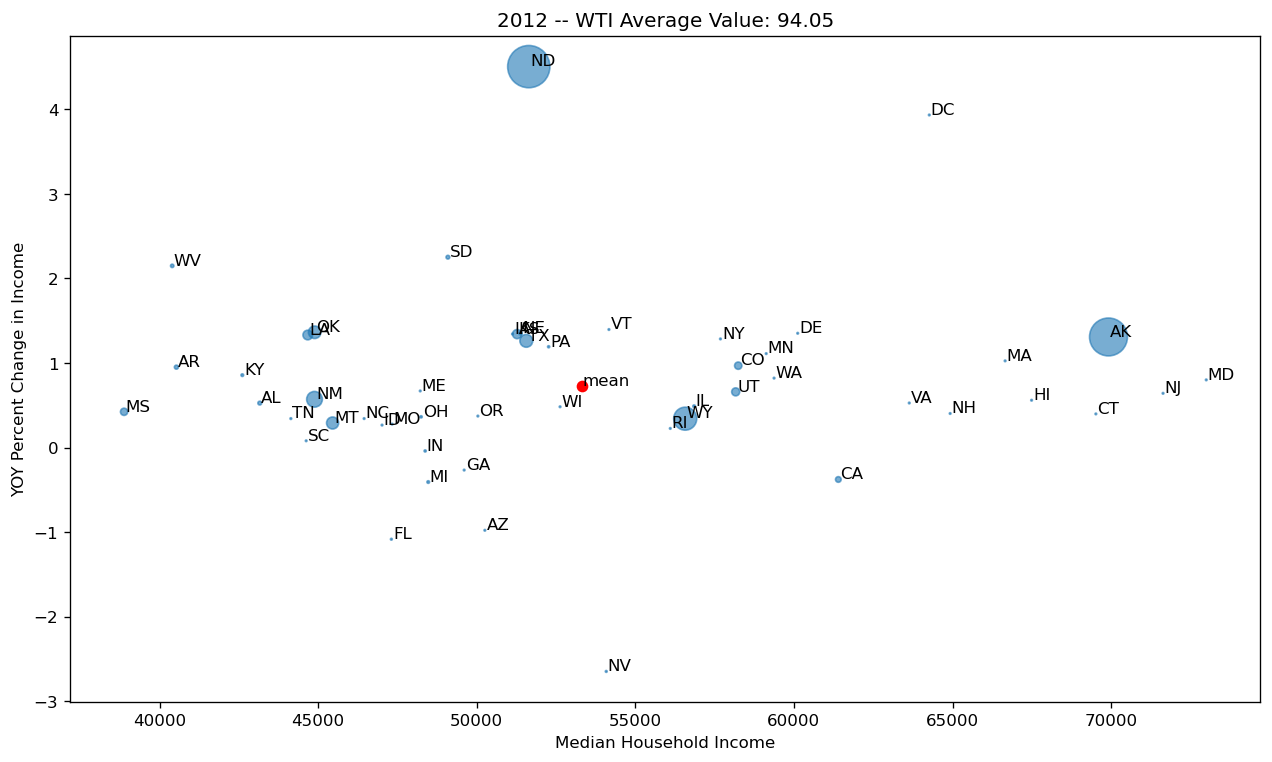

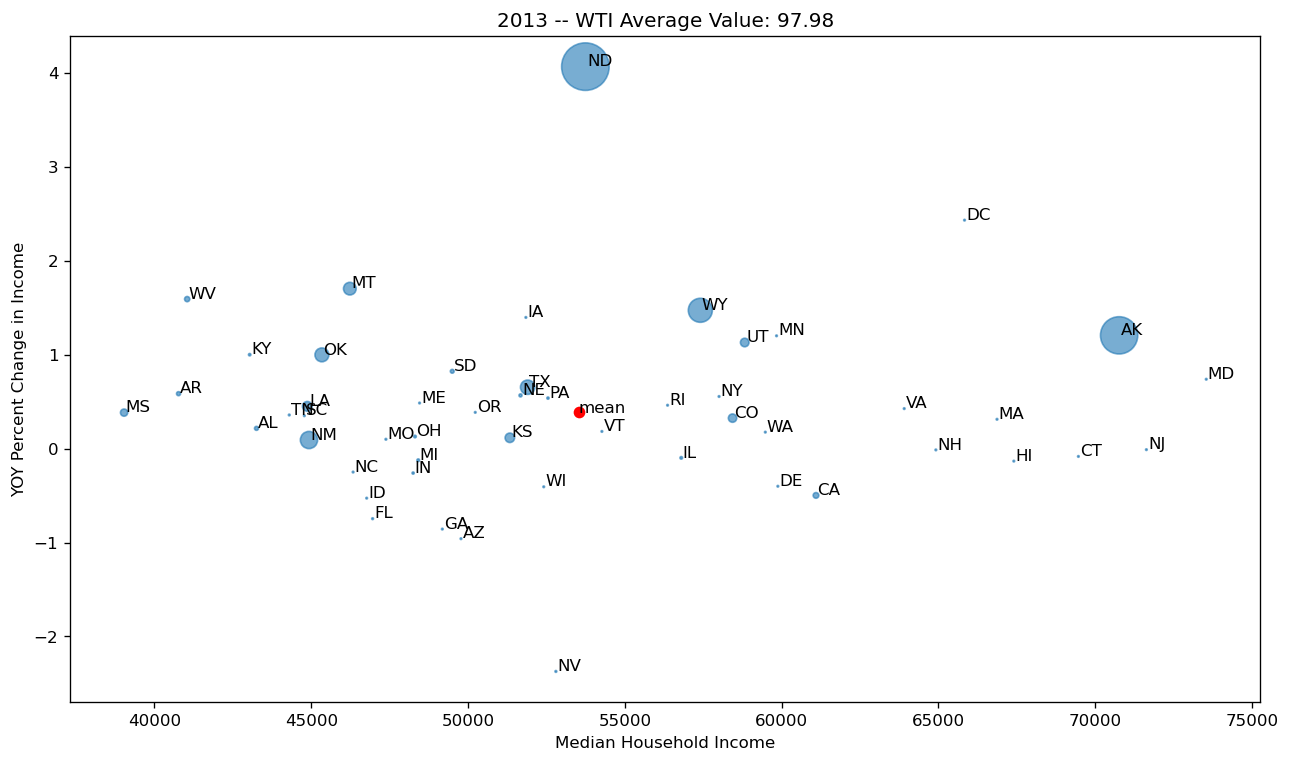

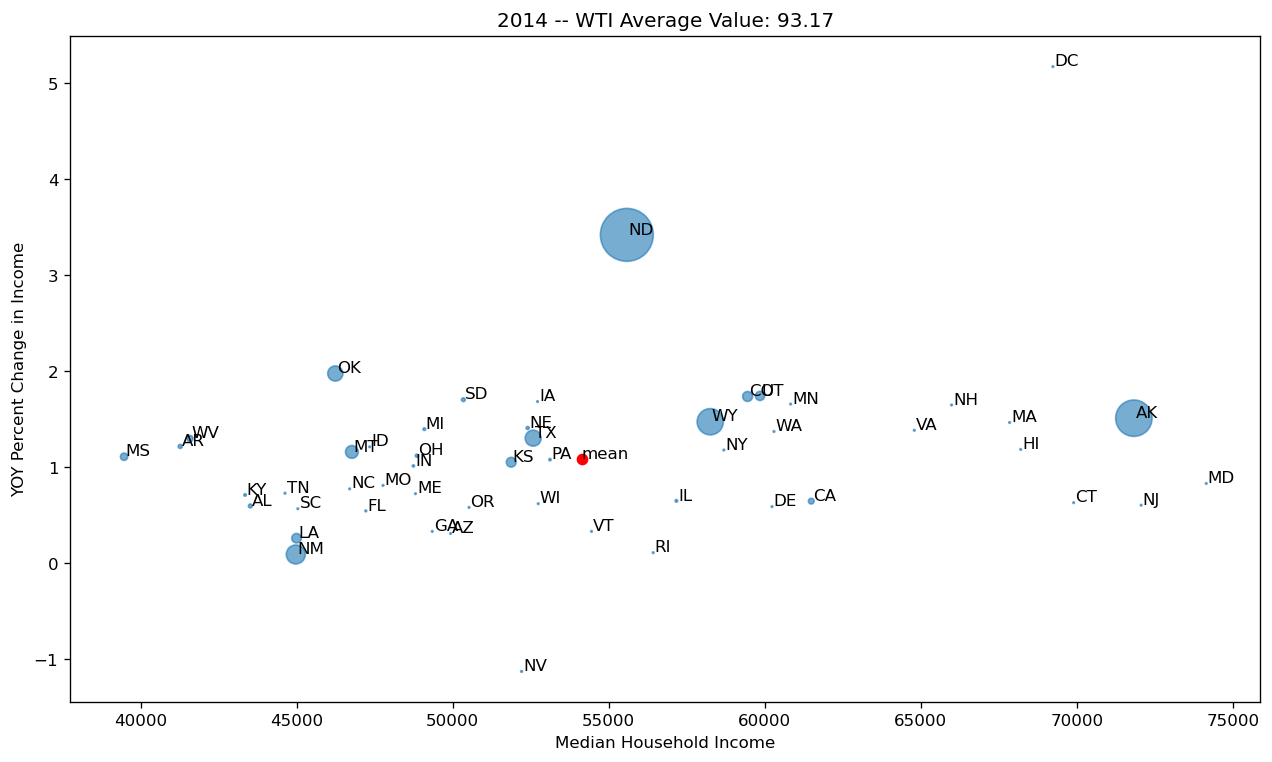

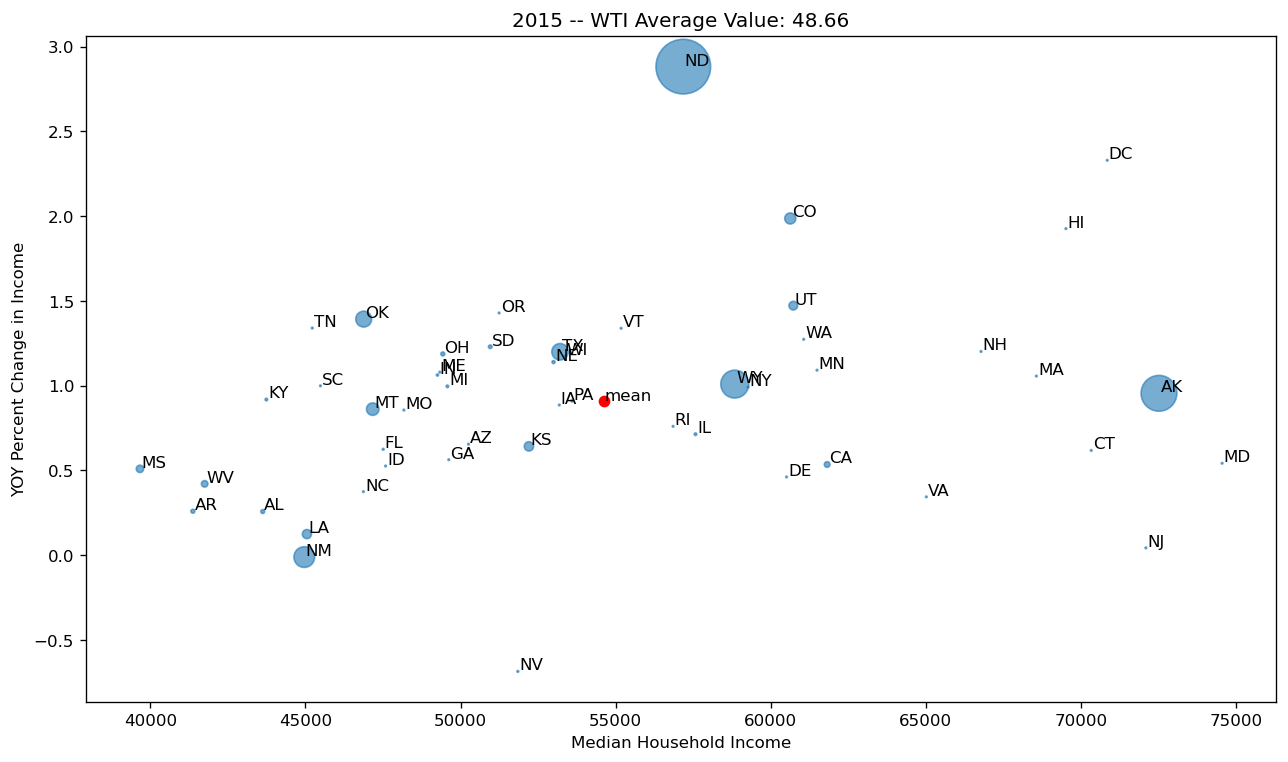

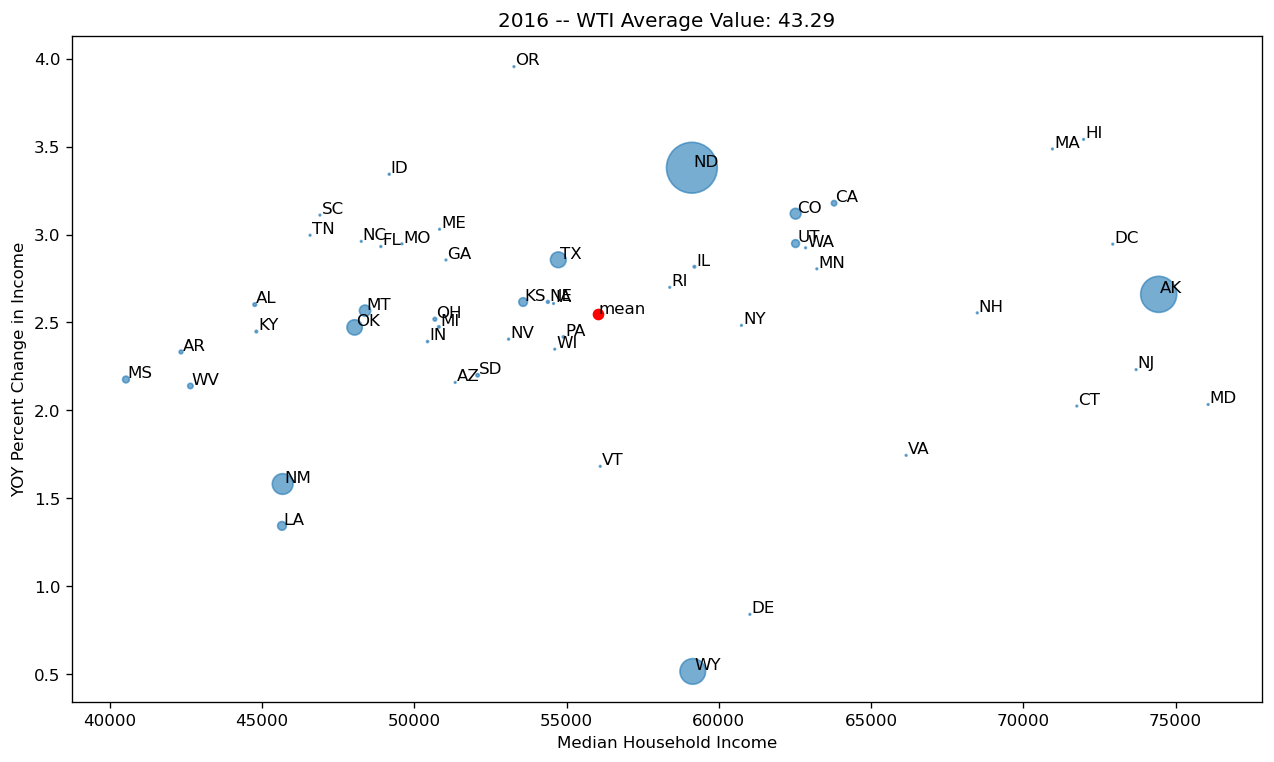

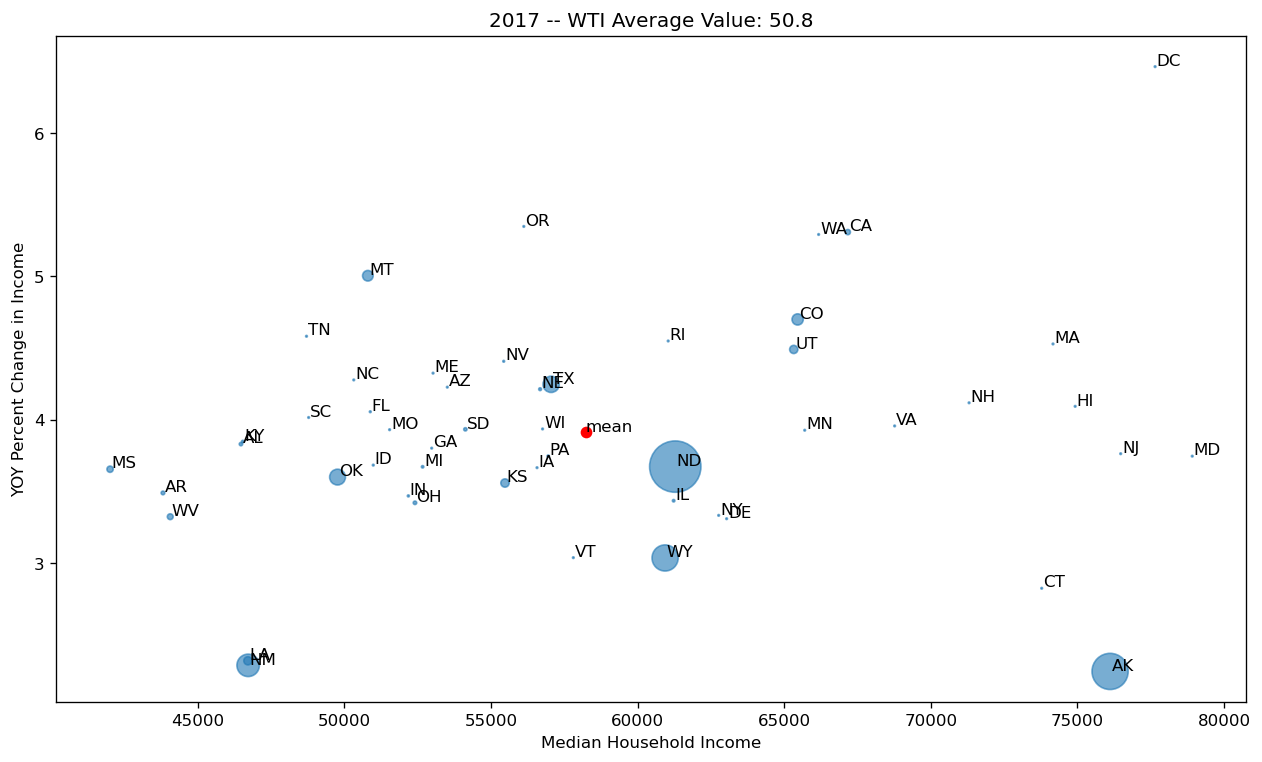

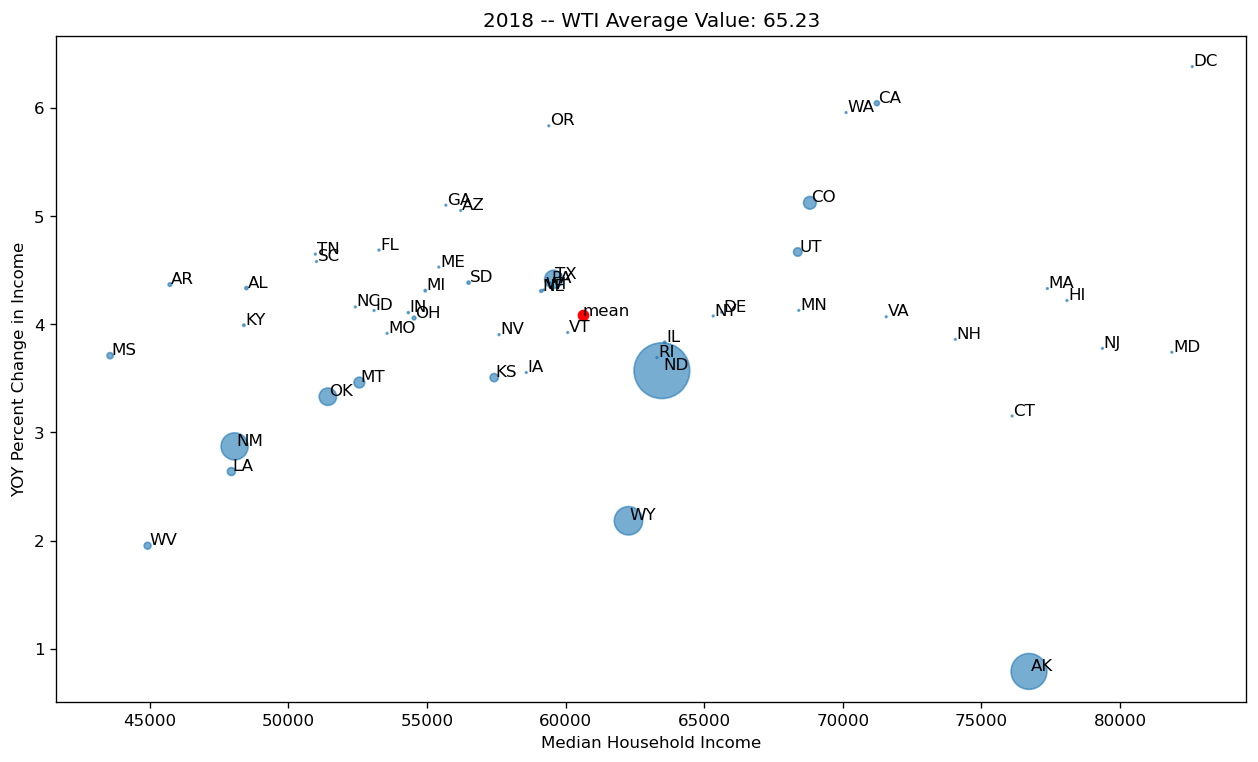

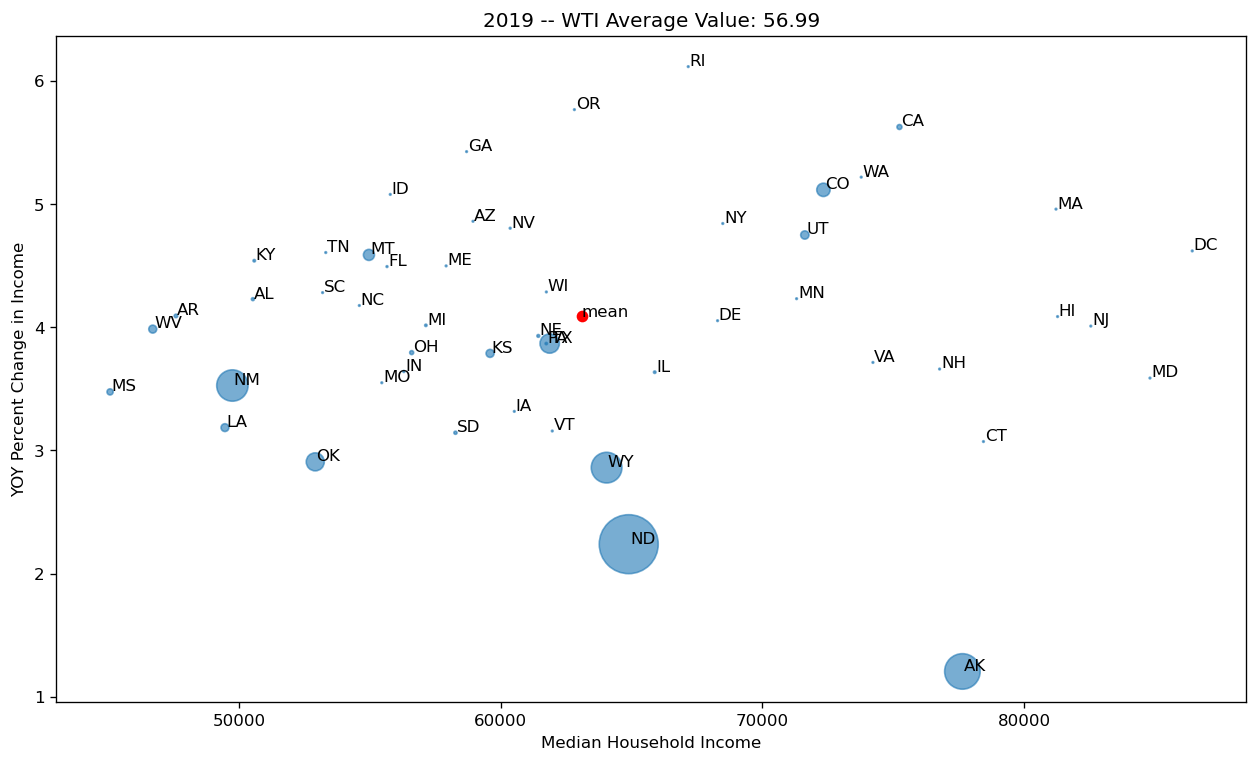

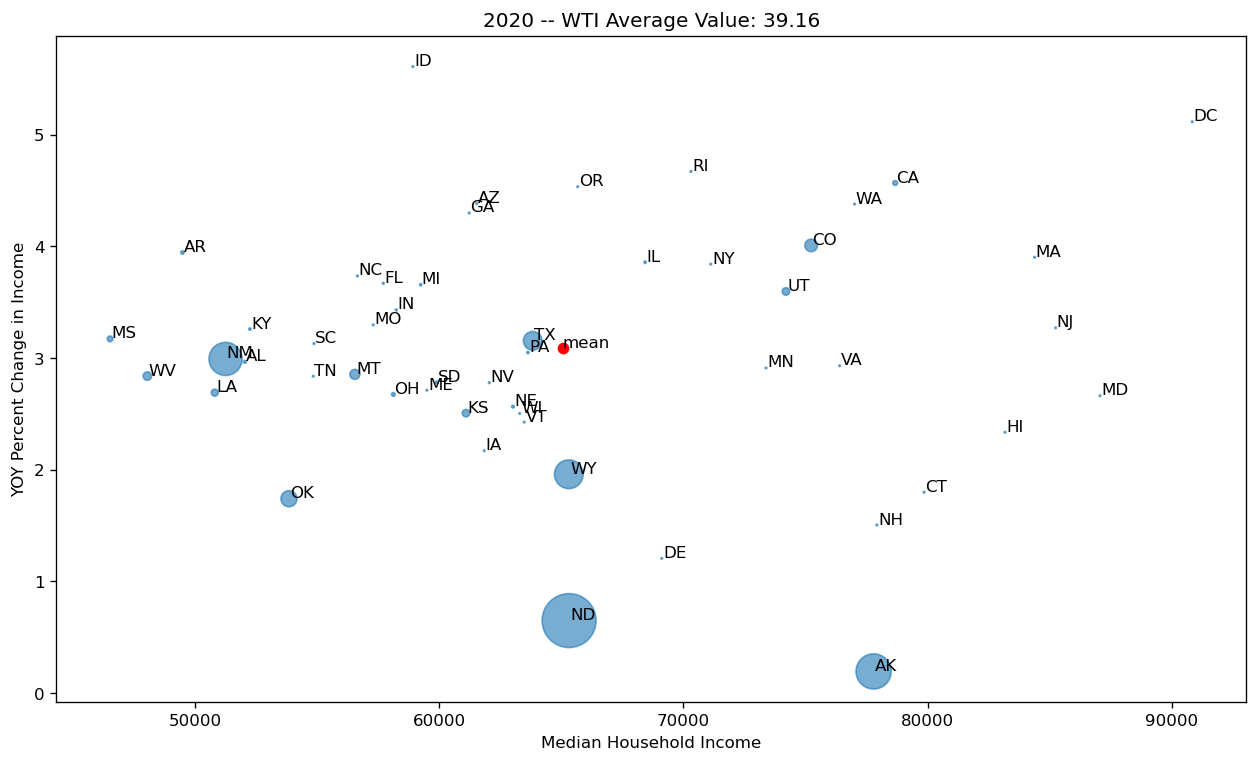

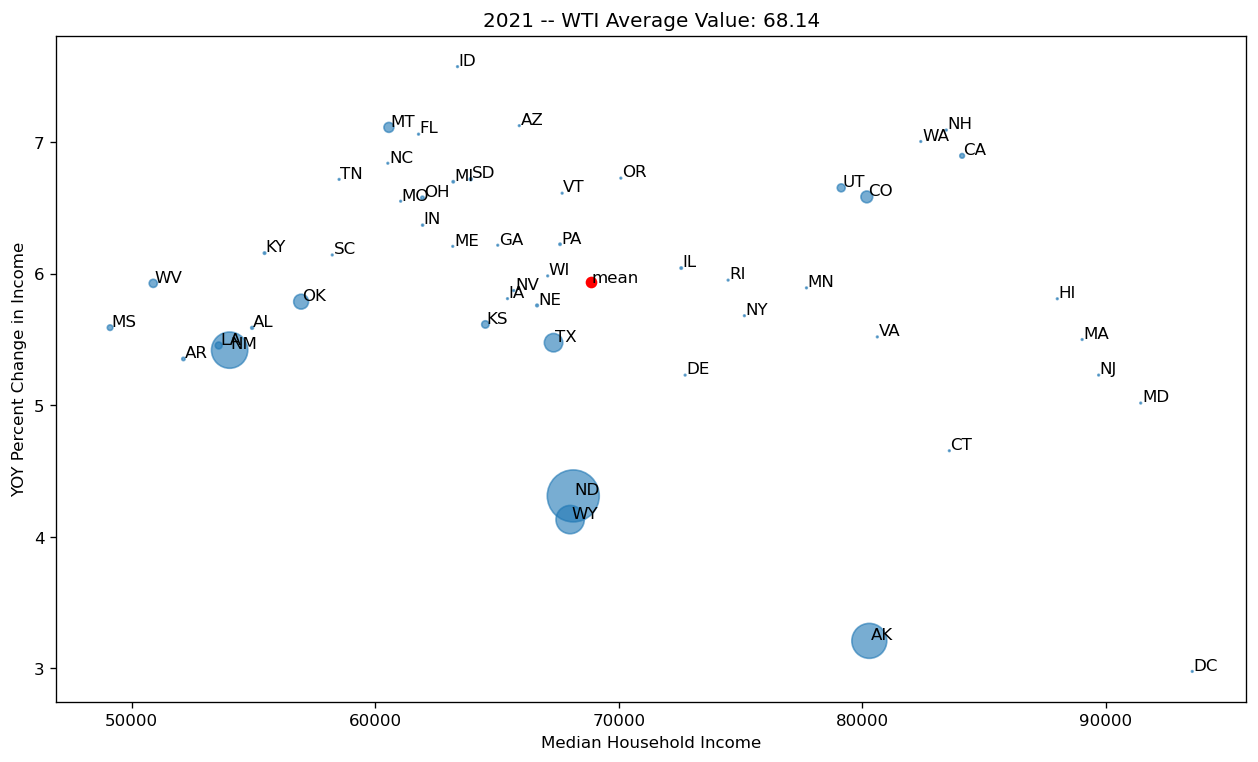

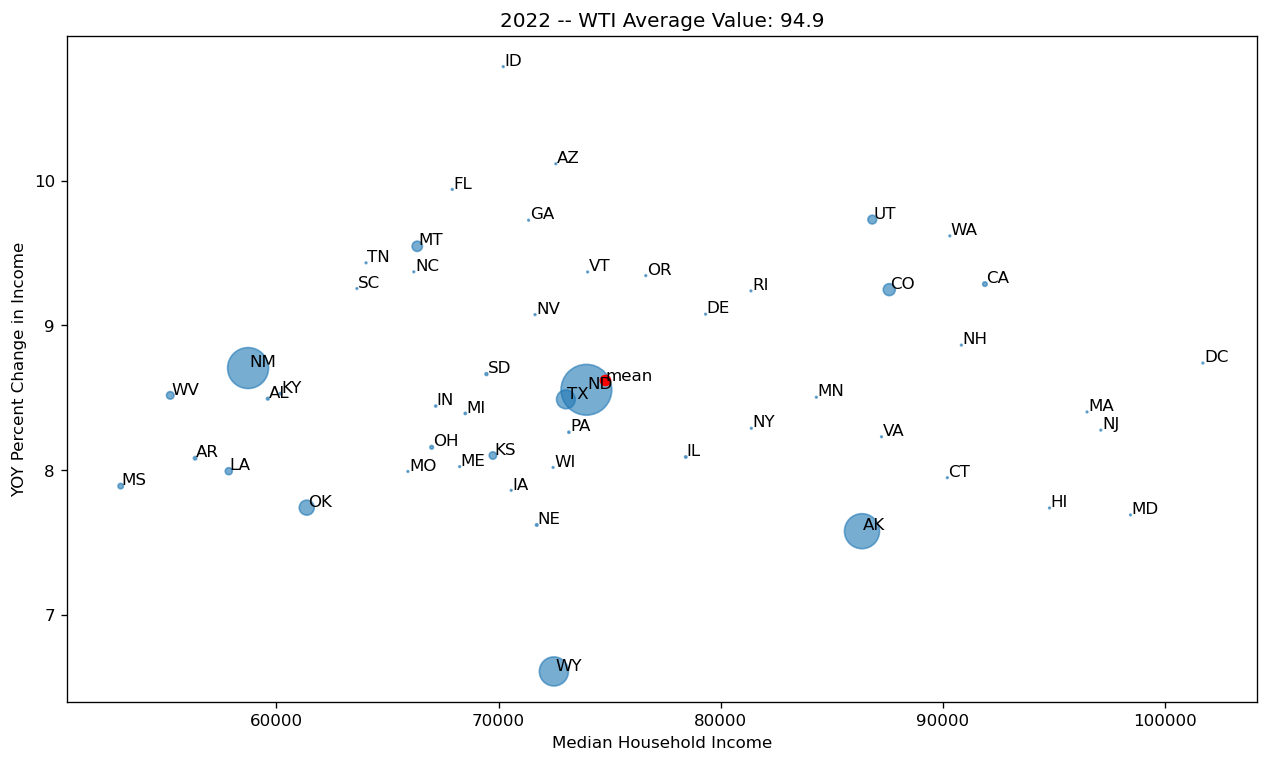

In [16]:
for year in range(2011,2023):
    data=acs_by_col[acs_by_col['Year']==year]
    x=data['INCOME AND BENEFITS (Not inflation Adjusted)__Median household income (dollars)'][:51]
    y=data['YOY_Change_in_Median_household_income'][:51]*100
    scale=[i+1 for i in data['daily_barrels_of_oil per working population'][:51]]
    fig = plt.figure(figsize=[12.8,7.2],dpi=120)
    ax1 = fig.add_subplot(111)
    ax1.set_ylabel('YOY Percent Change in Income')
    ax1.set_xlabel('Median Household Income')
    ax1.set_title(str(year)+' -- WTI Average Value: ' +str(round(wti_avg_by_year[year-2010],2)))
    ax1.scatter(x=x,y=y,s=scale,alpha=.6)
    ax1.scatter(x=x.mean(),y=y.mean(),c='r')
    ax1.text(x=x.mean(),y=y.mean(),s='mean')
    for i in range(len(states)):
        ax1.text(x.iloc[i]+50,y.iloc[i]+0.01,state_abbreviations[states[i]])
    plt.savefig(str(year)+'median income graph.jpg',format='jpg')
    plt.show()

In [17]:
def make_regression_graph(x,y,x_label,y_label,title,figsize=[12.8,7.2],dpi=120):
    ##make sure x and y are np.array or whatever
    fig = plt.figure(figsize=figsize,dpi=dpi)
    ax1 = fig.add_subplot(111)
    ax1.set_title(title)
    ax1.set_ylabel(y_label)
    ax1.set_xlabel(x_label)
    ax1.scatter(x=x,y=y)
    model=LinearRegression()
    model.fit(X=np.array(x).reshape(-1, 1),y=y)
    slope,intercept=model.coef_[0],model.intercept_
    r_sq=round(model.score(X=np.array(x).reshape(-1, 1),y=y),2)
    ax1.plot(x, intercept + slope*x, 'r', label='R^2= '+str(r_sq))
    plt.legend()
    plt.show()

In [18]:
housing_data=pd.read_csv('..\\..\\Downloads\\Freddie_mac_housing.csv',index_col=['Date'])
housing_data=housing_data.sort_index()
target_states=housing_data.columns[:5]
for col in housing_data.columns:
        housing_data[str(col)+' YOY_change']=housing_data[col].pct_change()
housing_data

,North Dakota,Alaska,Wyoming,Oklahoma,Texas,U.S.,North Dakota YOY_change,Alaska YOY_change,Wyoming YOY_change,Oklahoma YOY_change,Texas YOY_change,U.S. YOY_change
Date,,,,,,,,,,,,
2004,125.47,134.04,135.69,116.41,114.15,144.04,NaN,NaN,NaN,NaN,NaN,NaN
2005,135.92,148.58,151.66,123.35,120.80,161.12,0.083287,0.108475,0.117695,0.059617,0.058257,0.118578
2006,141.65,155.75,169.50,128.14,127.41,162.85,0.042157,0.048257,0.117632,0.038833,0.054719,0.010737
2007,146.68,155.67,175.59,130.88,129.67,154.33,0.035510,-0.000514,0.035929,0.021383,0.017738,-0.052318
2008,149.62,153.89,171.37,129.20,127.34,135.11,0.020044,-0.011434,-0.024033,-0.012836,-0.017969,-0.124538
2009,153.24,152.90,166.42,131.89,128.61,130.81,0.024195,-0.006433,-0.028885,0.020820,0.009973,-0.031826
2010,157.32,155.60,161.47,128.69,125.51,124.45,0.026625,0.017659,-0.029744,-0.024263,-0.024104,-0.048620
2011,165.76,153.73,161.40,128.25,126.47,120.96,0.053649,-0.012018,-0.000434,-0.003419,0.007649,-0.028043
2012,178.97,158.49,166.50,132.67,133.96,128.63,0.079694,0.030963,0.031599,0.034464,0.059224,0.063409


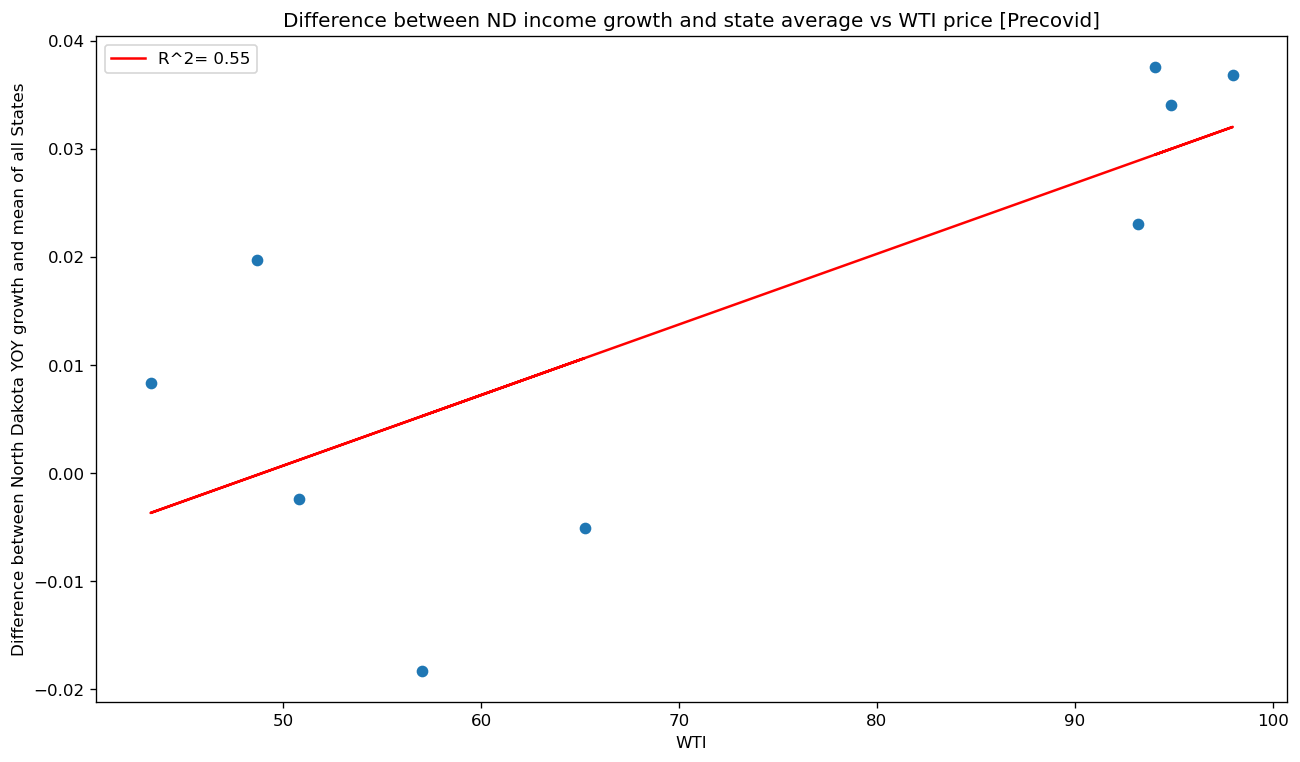

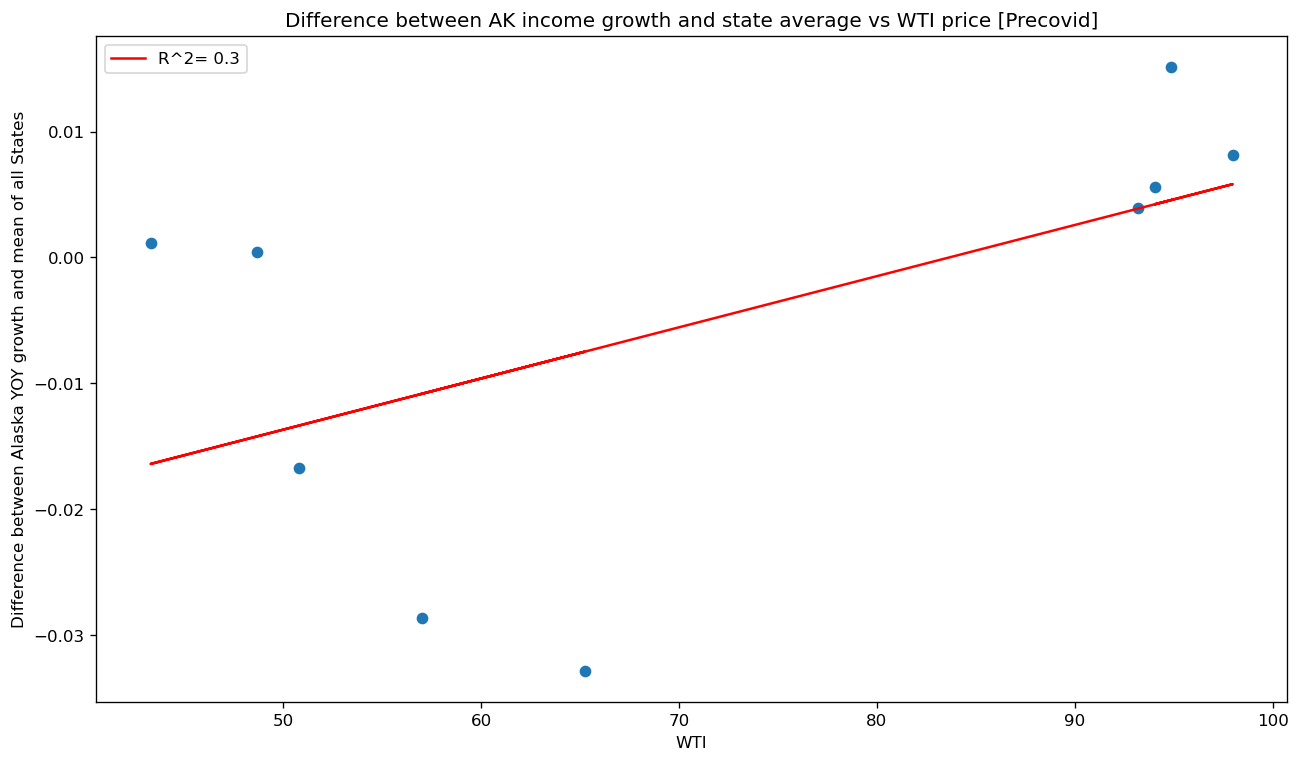

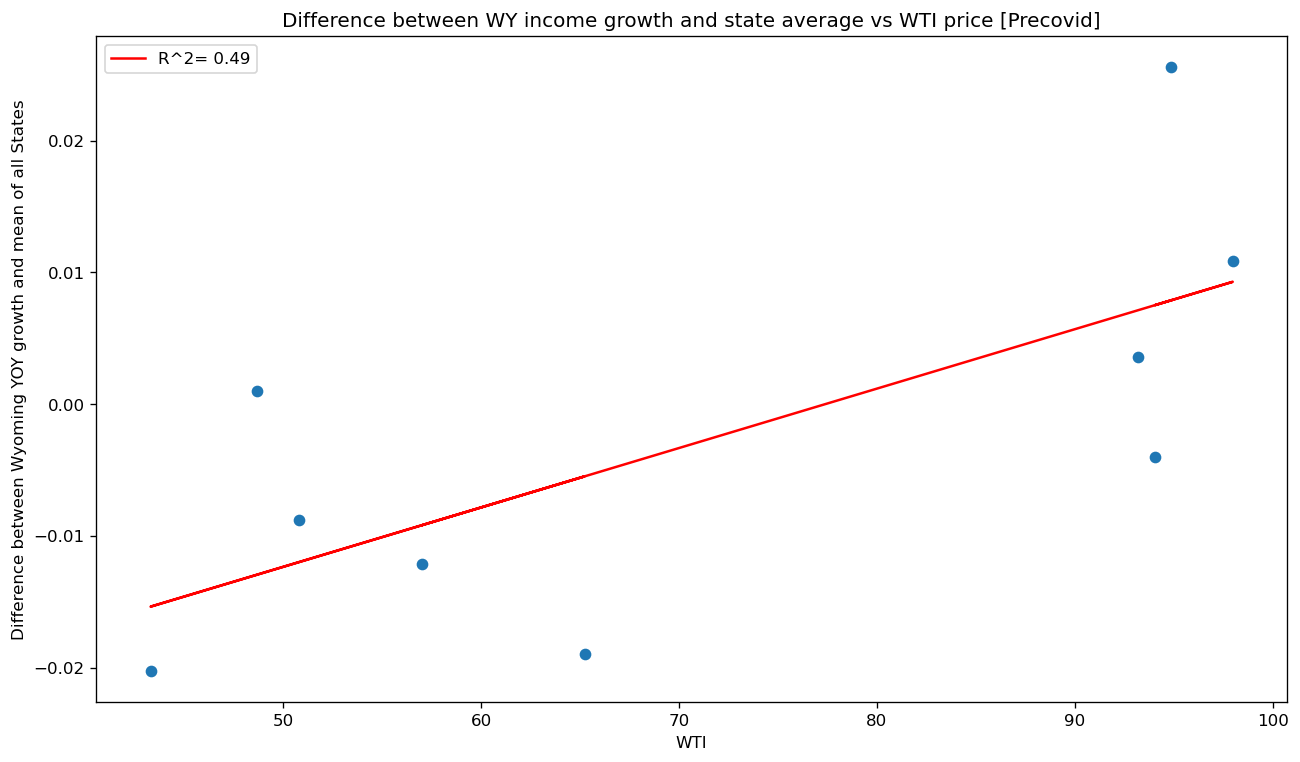

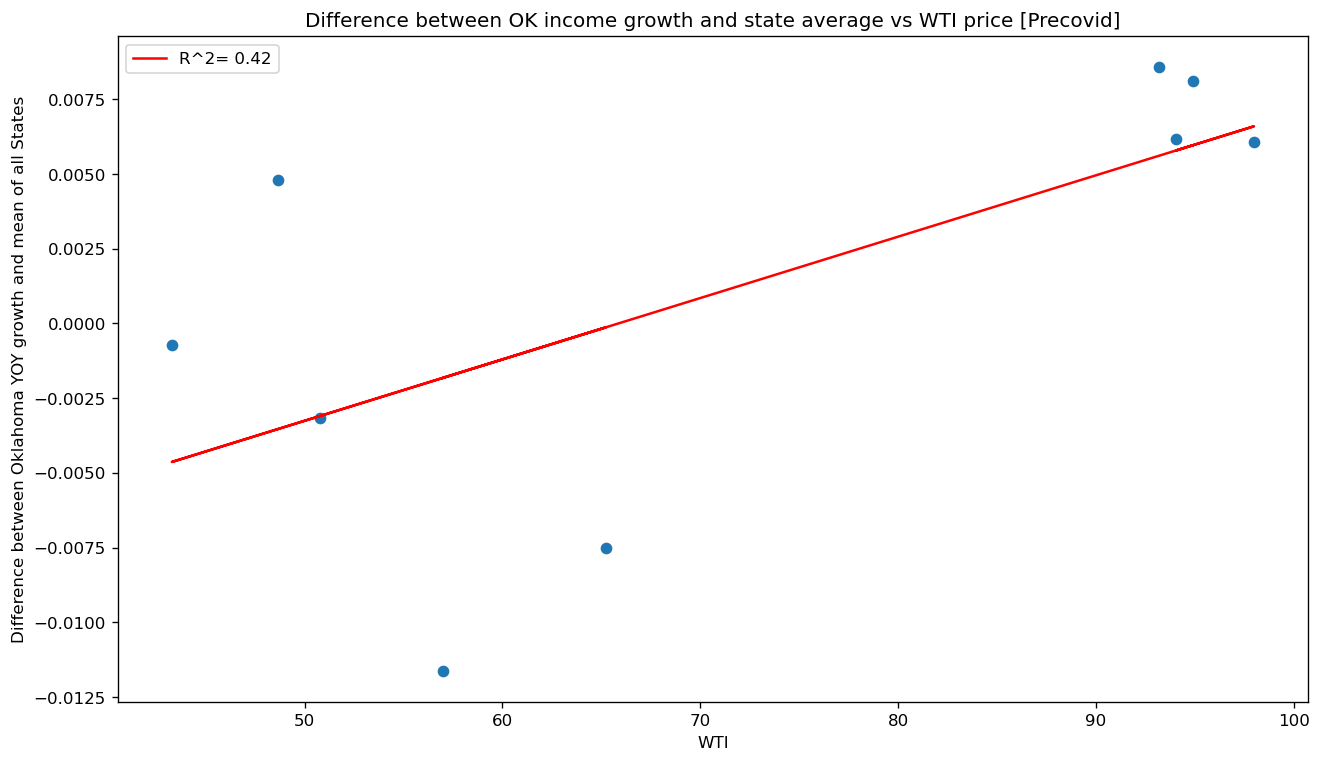

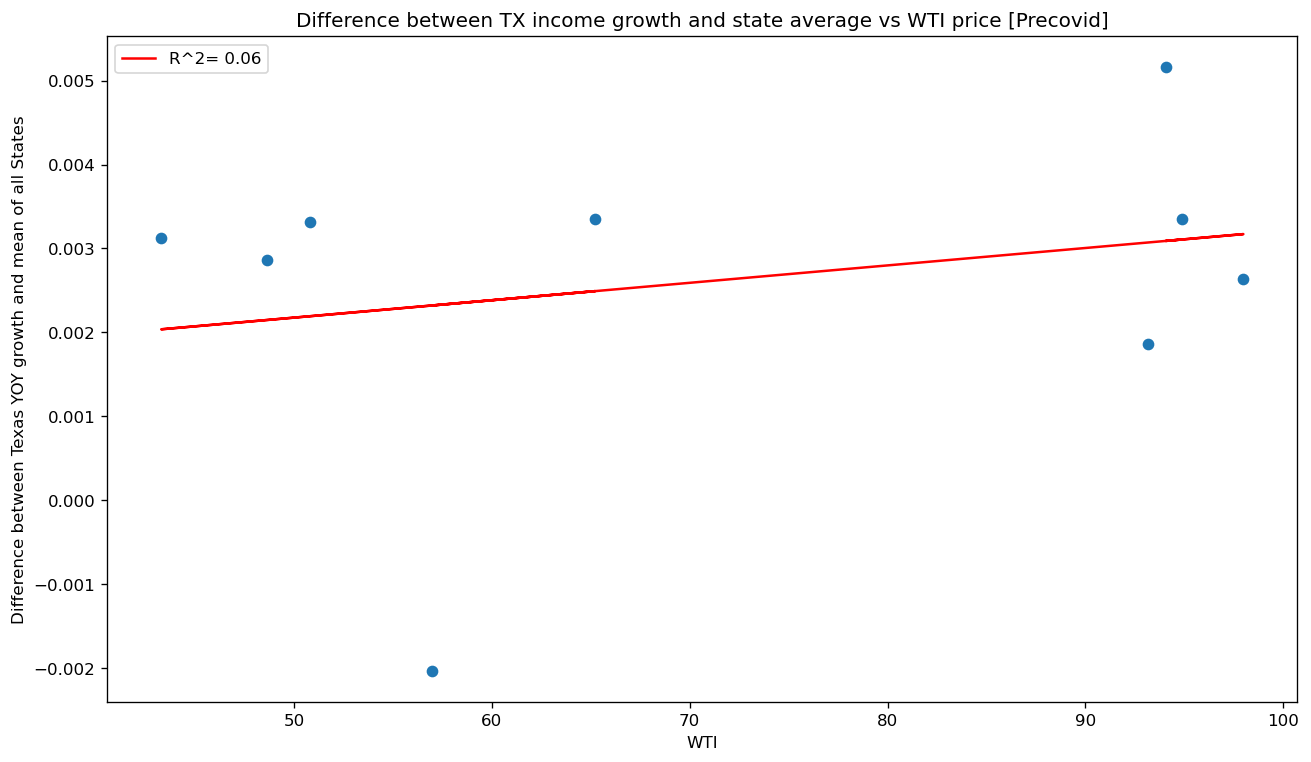

In [19]:
for state in target_states:
    data=acs_by_col[acs_by_col['State']==state]
    y=data['YOY_Change_in_Median_household_income'][1:10]-avg_state_median_income_by_year_YOY[0:9]
    x=np.array(wti_avg_by_year[1:10])
    x_label='WTI'
    y_label=f"Difference between {state} YOY growth and mean of all States"
    title=f"Difference between {state_abbreviations[state]} income growth and state average vs WTI price [Precovid]"
    make_regression_graph(x,y,x_label,y_label,title,figsize=[12.8,7.2],dpi=120)

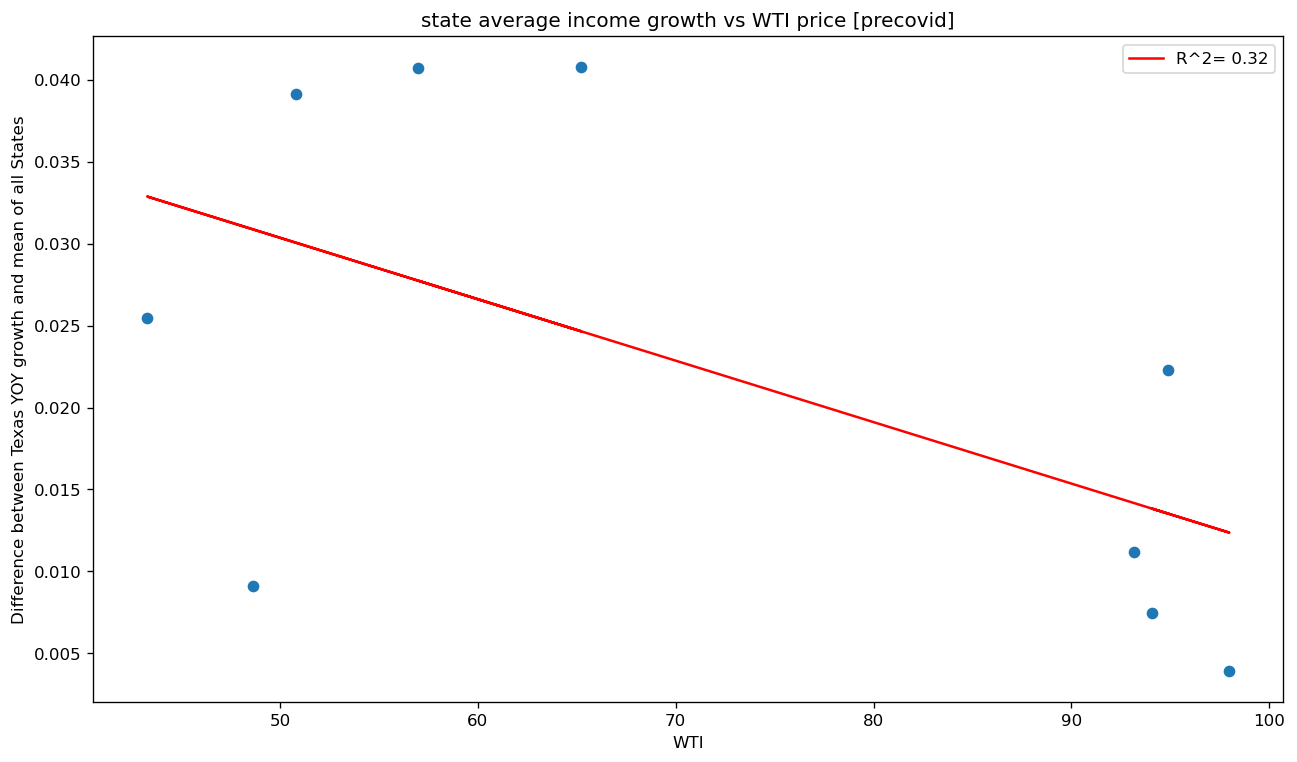

In [20]:
y=np.array(avg_state_median_income_by_year_YOY[0:9])
x=np.array(wti_avg_by_year[1:10])

title='state average income growth vs WTI price [precovid]'
xlabel='WTI'
ylabel='Median Household income growth YOY'
make_regression_graph(x,y,x_label,y_label,title,figsize=[12.8,7.2],dpi=120)

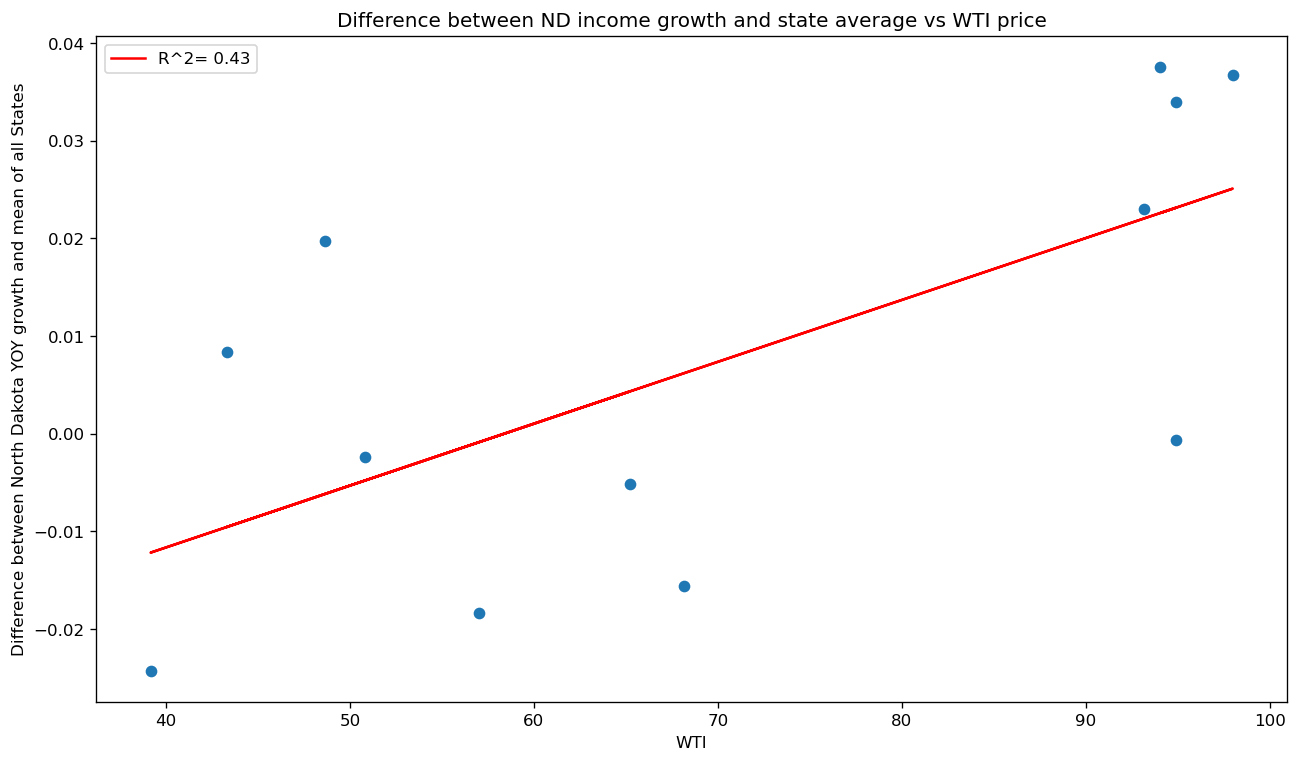

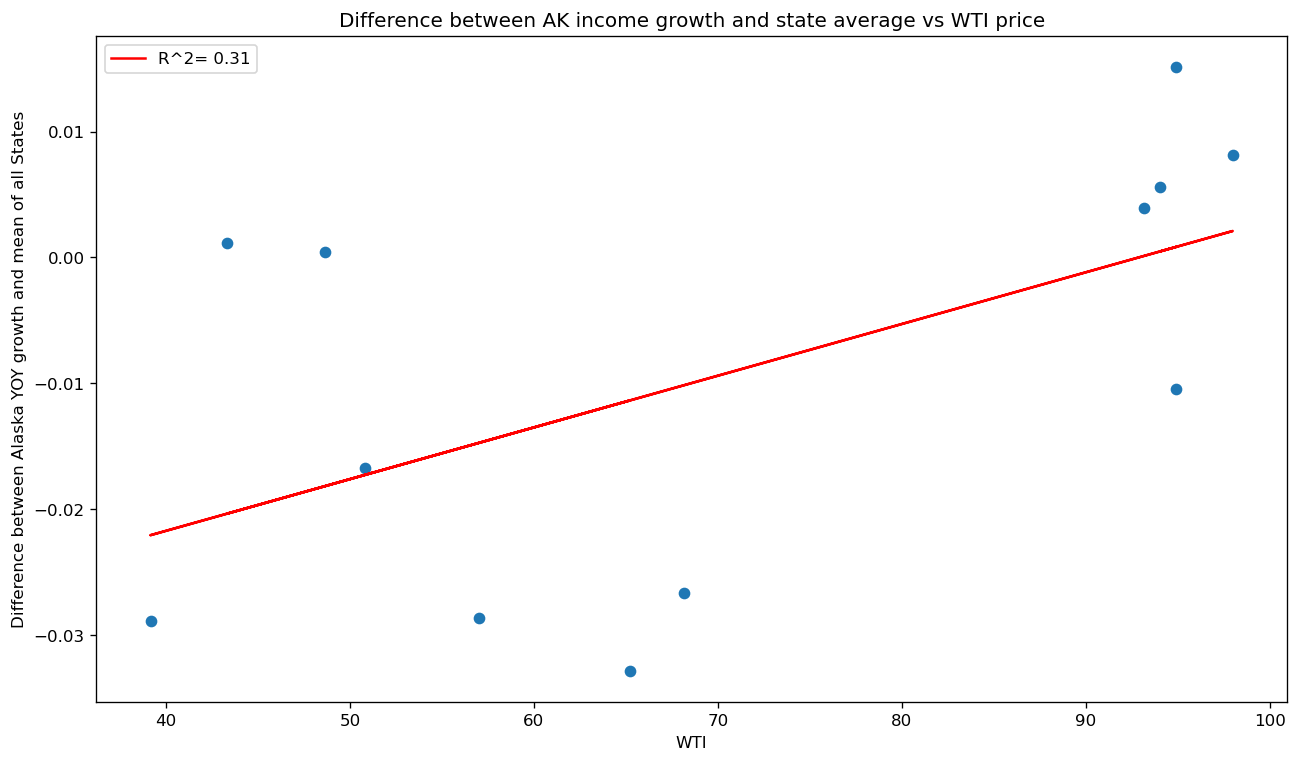

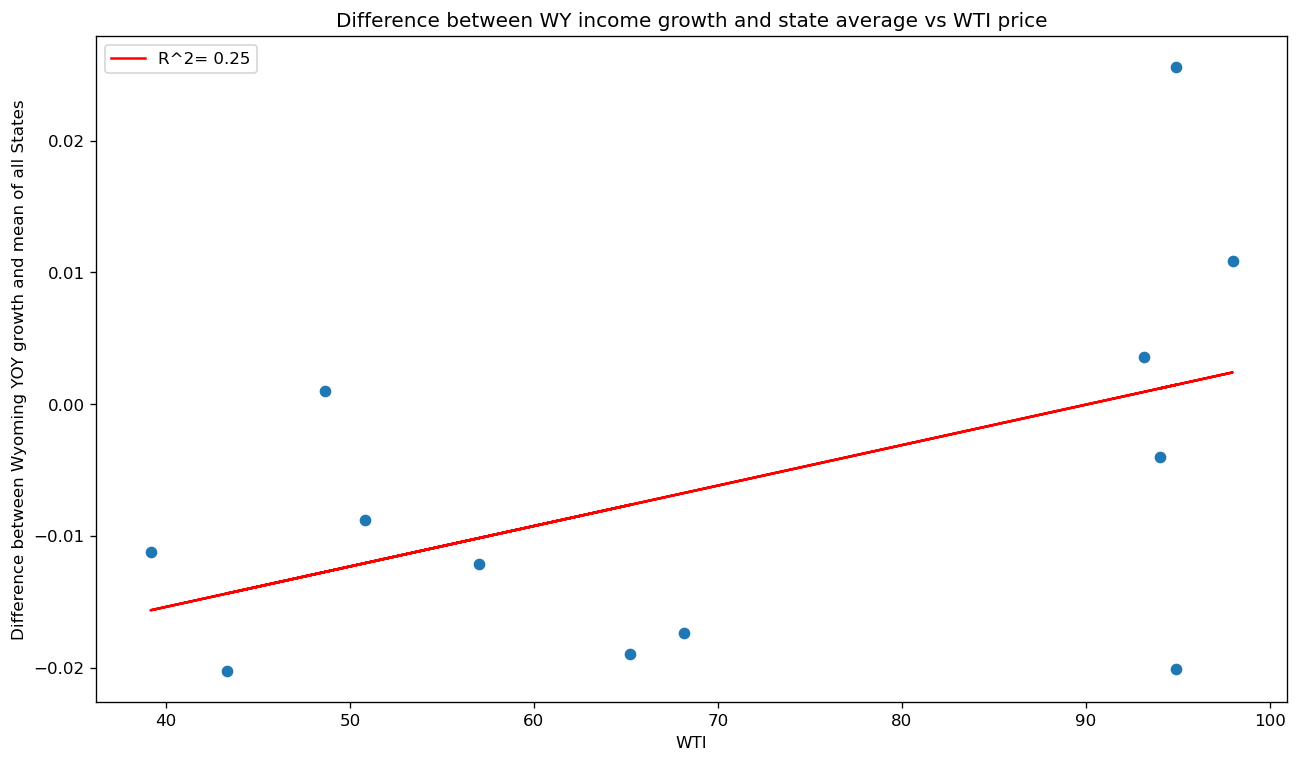

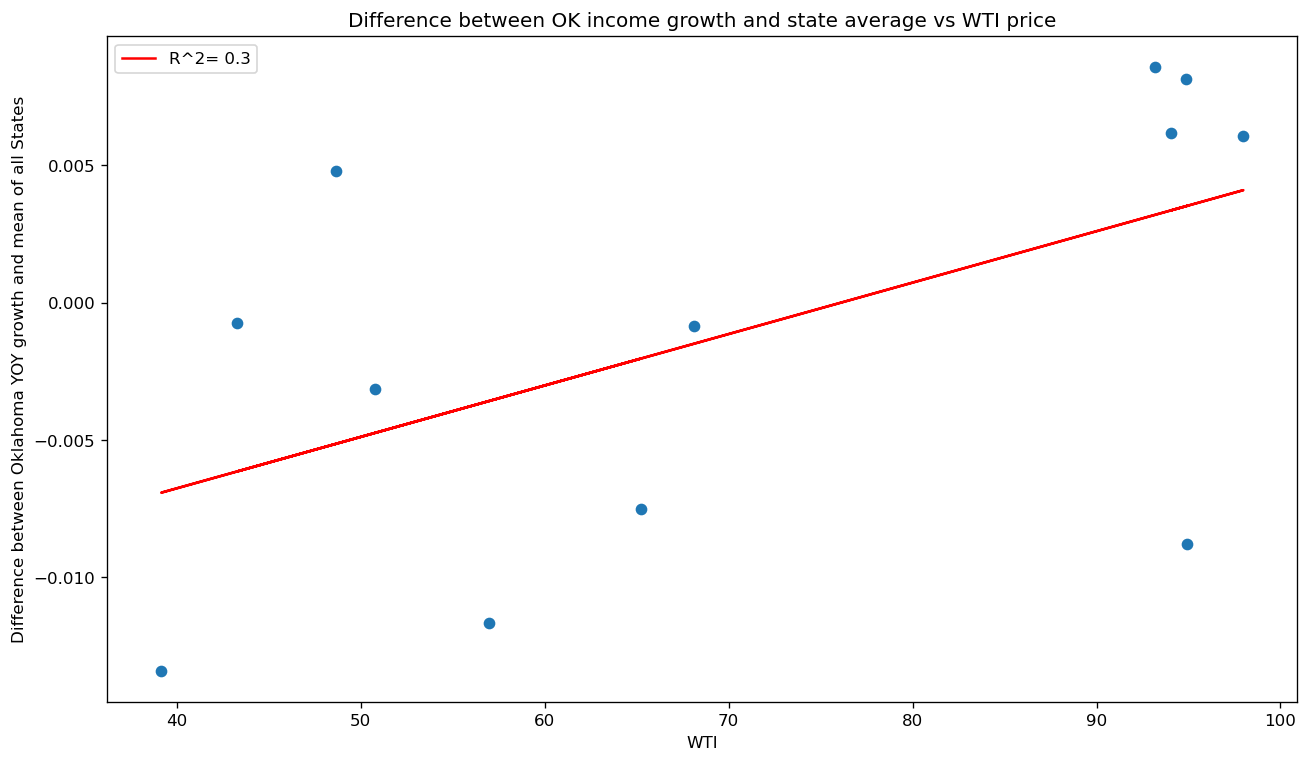

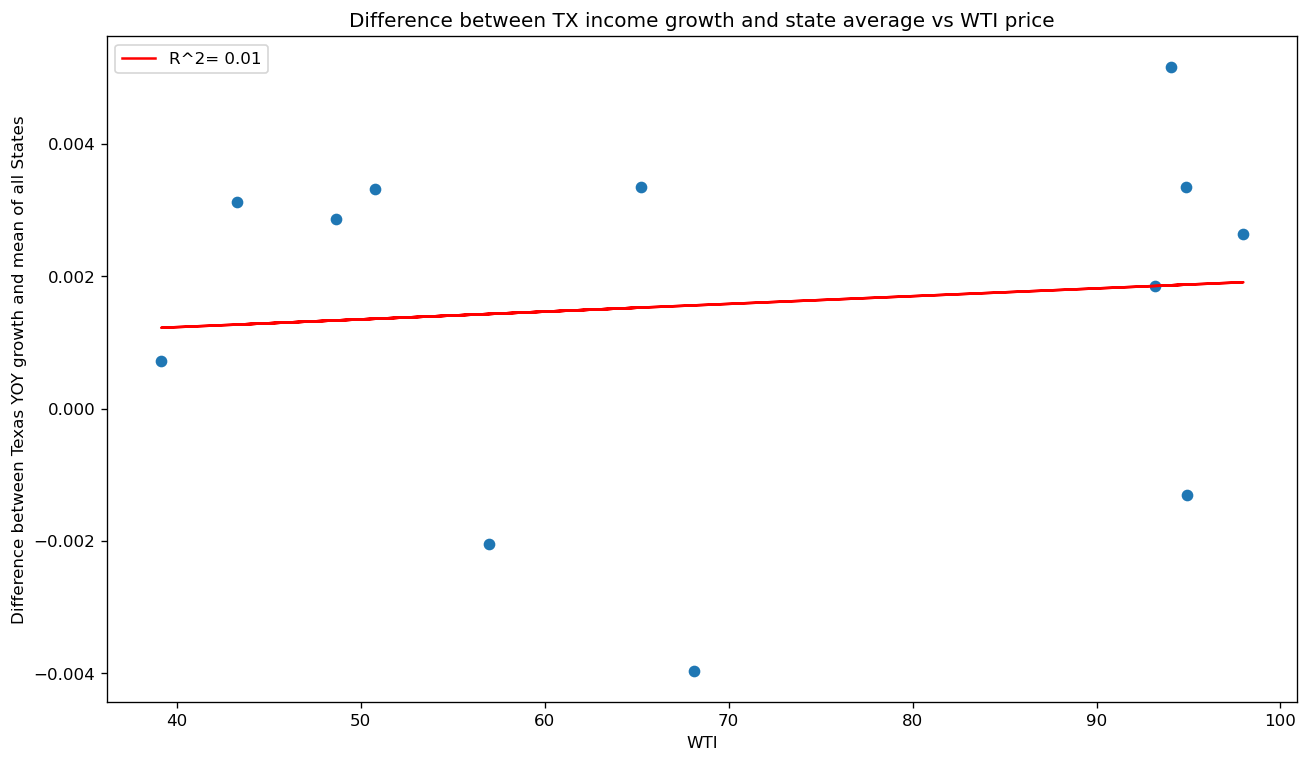

In [21]:
for state in target_states:
    data=acs_by_col[acs_by_col['State']==state]
    y=data['YOY_Change_in_Median_household_income'][1:]-avg_state_median_income_by_year_YOY
    x=np.array(wti_avg_by_year[1:])
    x_label='WTI'
    y_label=f"Difference between {state} YOY growth and mean of all States"
    title=f"Difference between {state_abbreviations[state]} income growth and state average vs WTI price"
    make_regression_graph(x,y,x_label,y_label,title,figsize=[12.8,7.2],dpi=120)

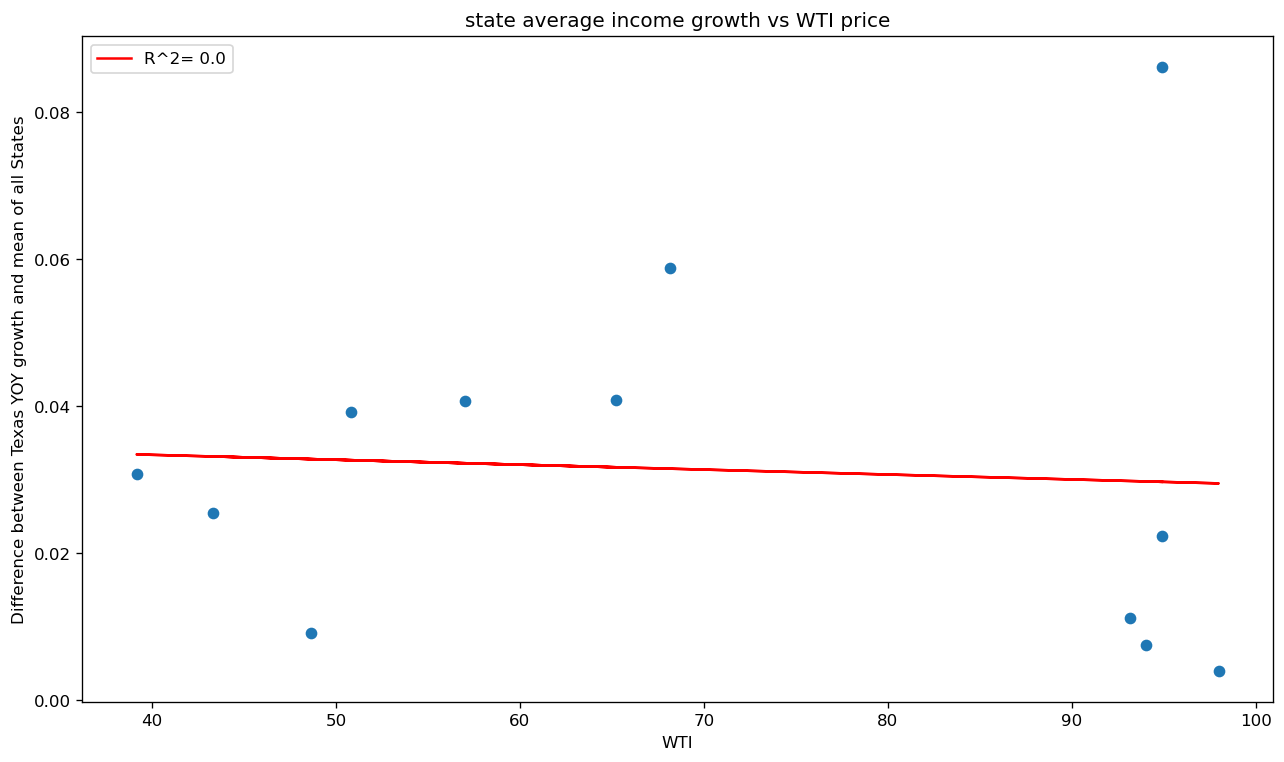

In [22]:
y=np.array(avg_state_median_income_by_year_YOY)
x=np.array(wti_avg_by_year[1:])

title='state average income growth vs WTI price'
xlabel='WTI'
ylabel='Median Household income growth YOY'
make_regression_graph(x,y,x_label,y_label,title,figsize=[12.8,7.2],dpi=120)

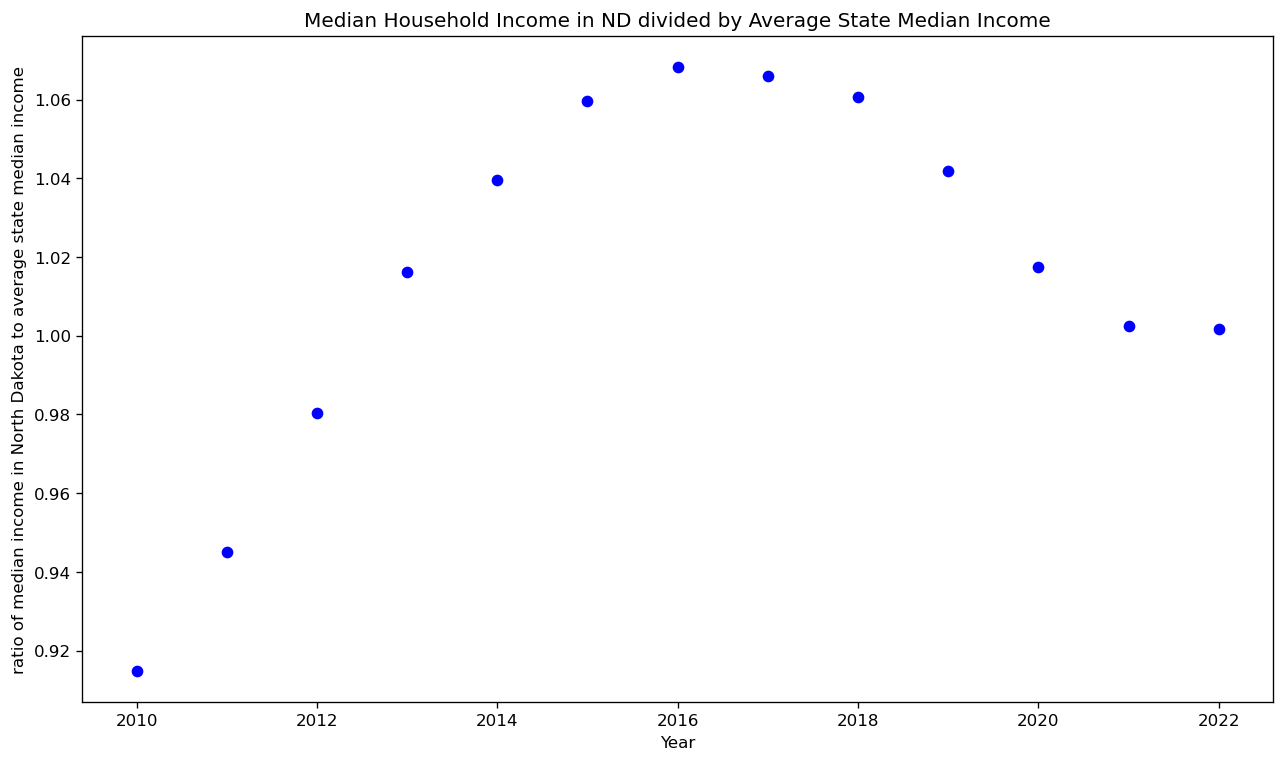

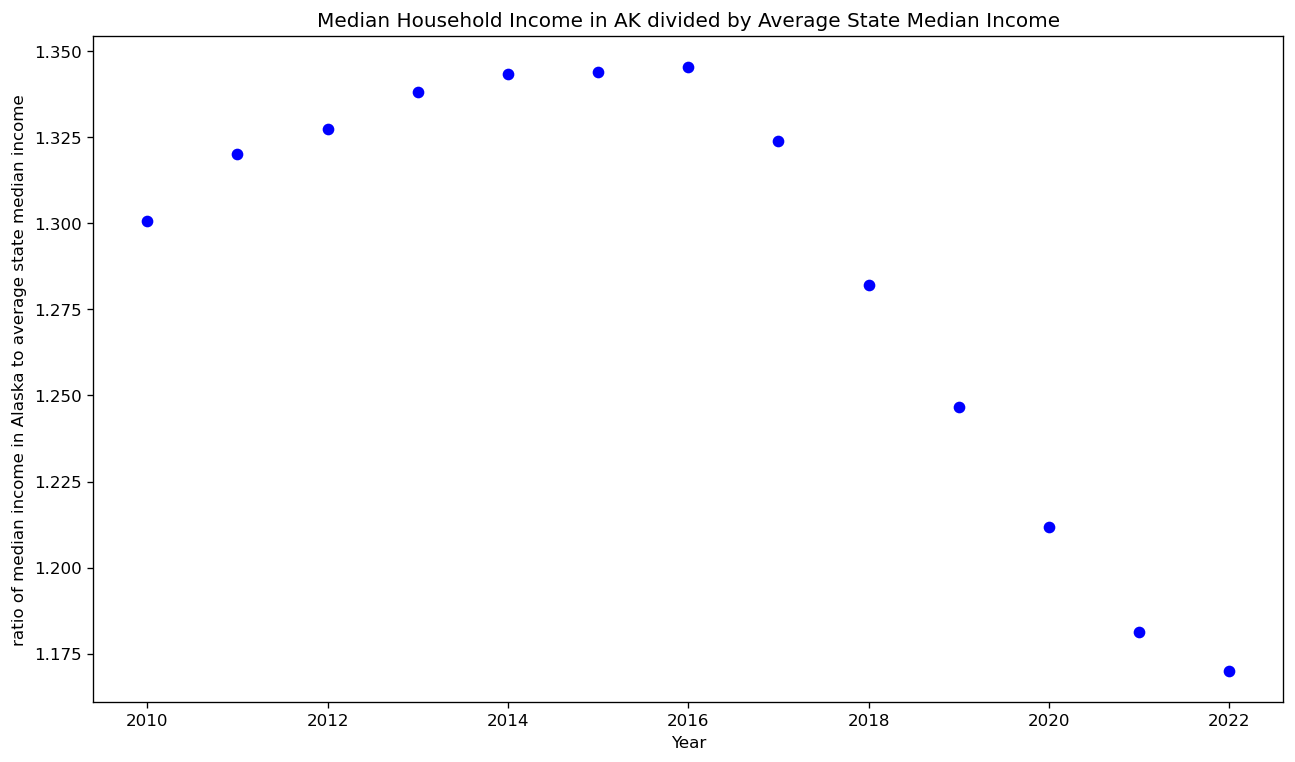

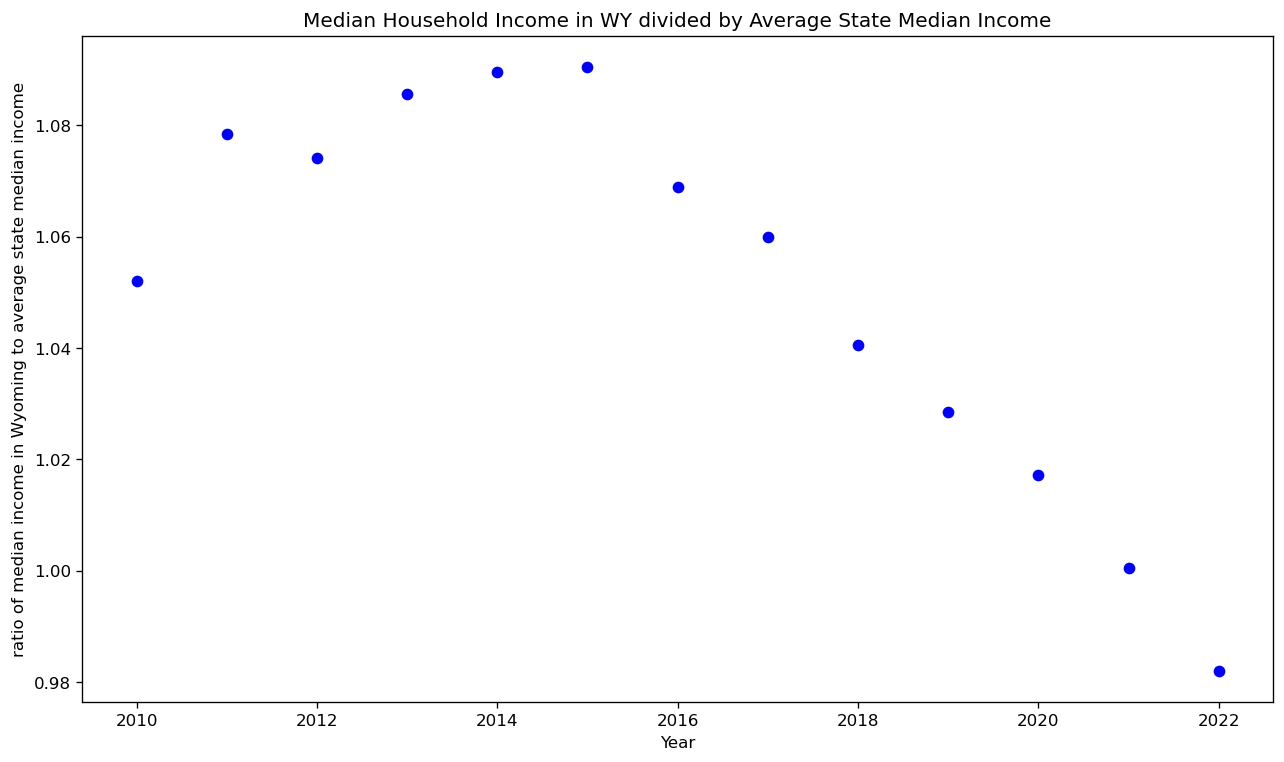

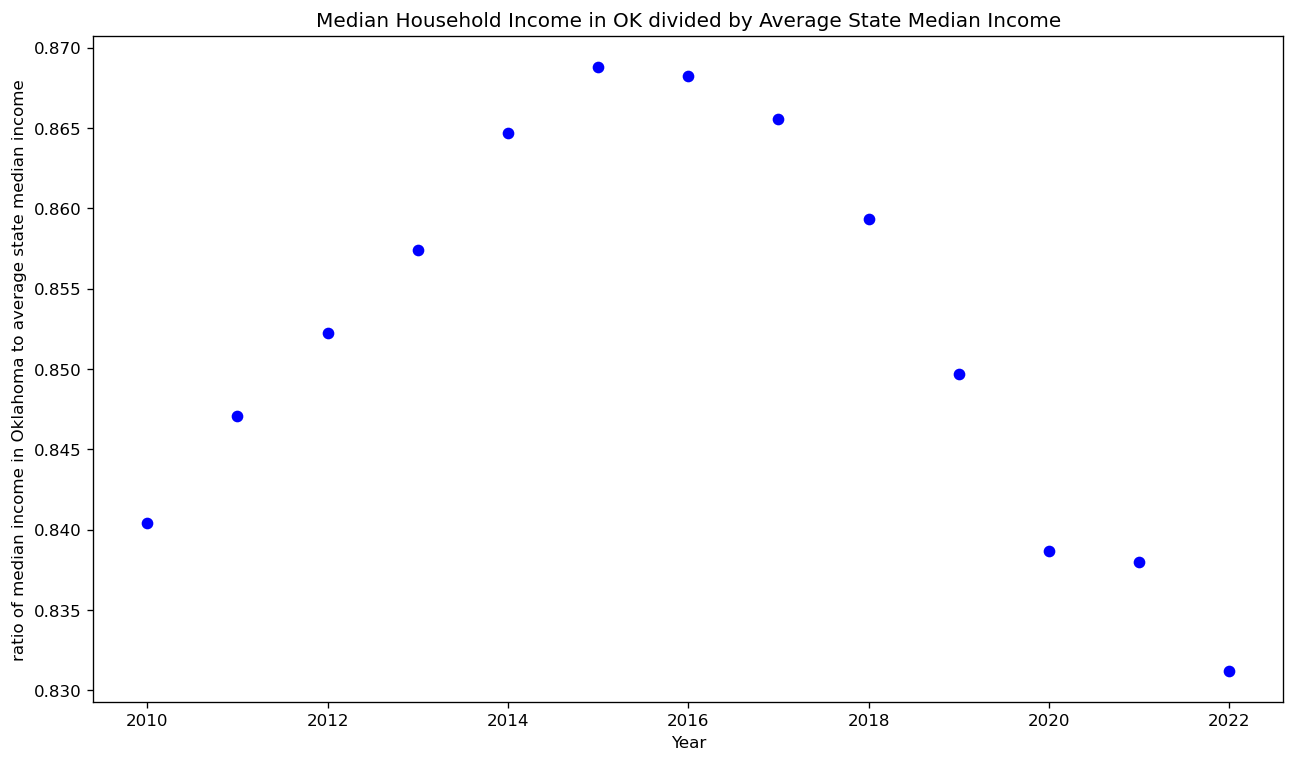

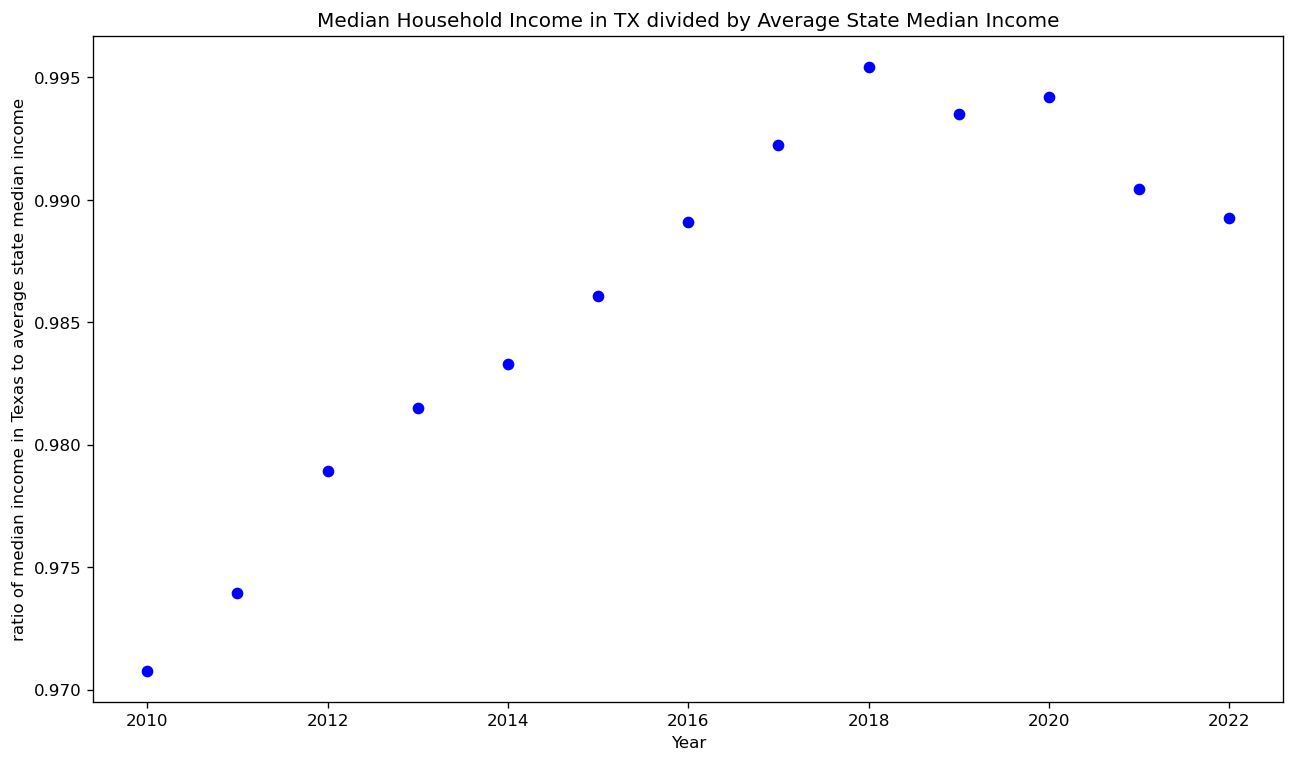

In [23]:
for state in target_states:
    data=acs_by_col[acs_by_col['State']==state]
    y=data['INCOME AND BENEFITS (Not inflation Adjusted)__Median household income (dollars)']/avg_state_median_income_by_year
    x=[i for i in range(2010,2023)]
    fig = plt.figure(figsize=[12.8,7.2],dpi=120)
    ax1 = fig.add_subplot(111)
    ax1.set_ylabel(f"ratio of median income in {state} to average state median income")
    ax1.set_xlabel('Year')
    ax1.set_title(f"Median Household Income in {state_abbreviations[state]} divided by Average State Median Income")
    ax1.scatter(x,y=y,label='Income Ratio',c='blue')
    """ax2 = ax1.twinx()
    ax2.plot(x,wti_avg_by_year,label='WTI average price',c='red')
    ax2.set_ylabel("Average Year WTI price")
    plt.legend()"""
    plt.show()
    

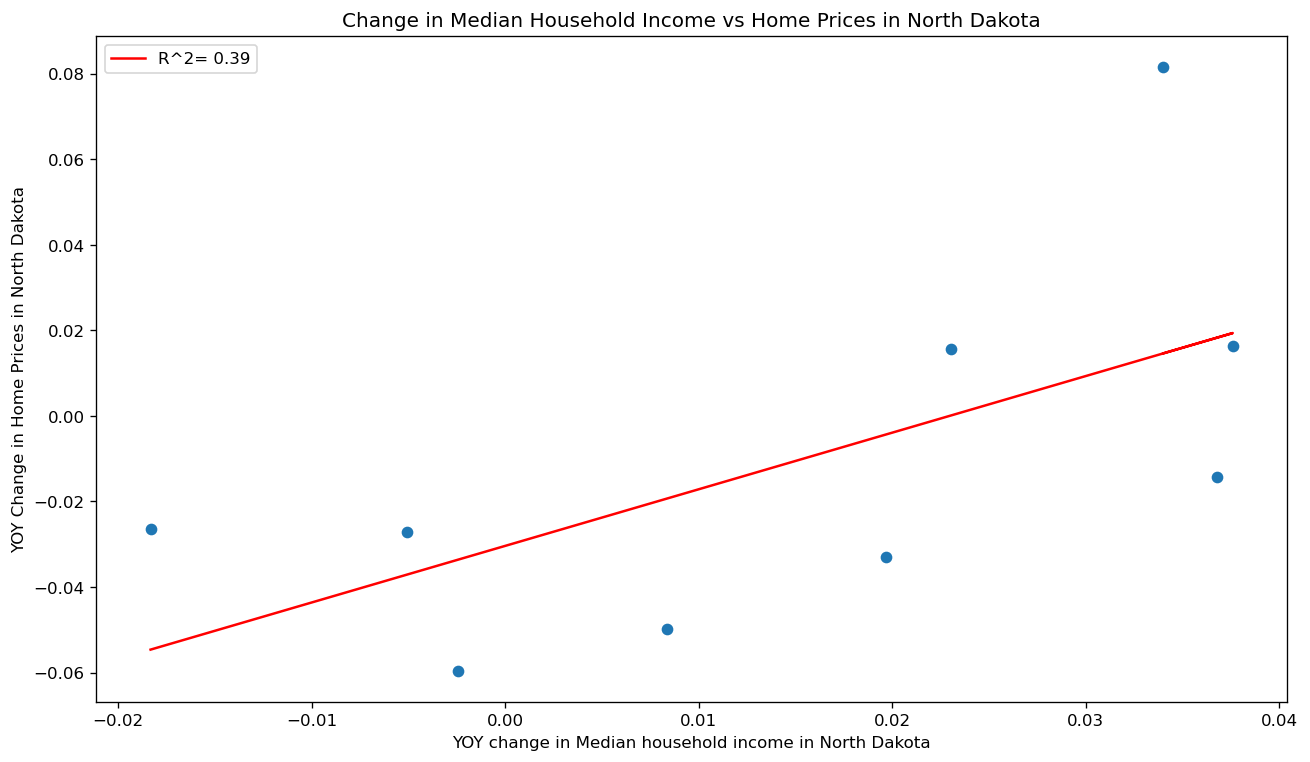

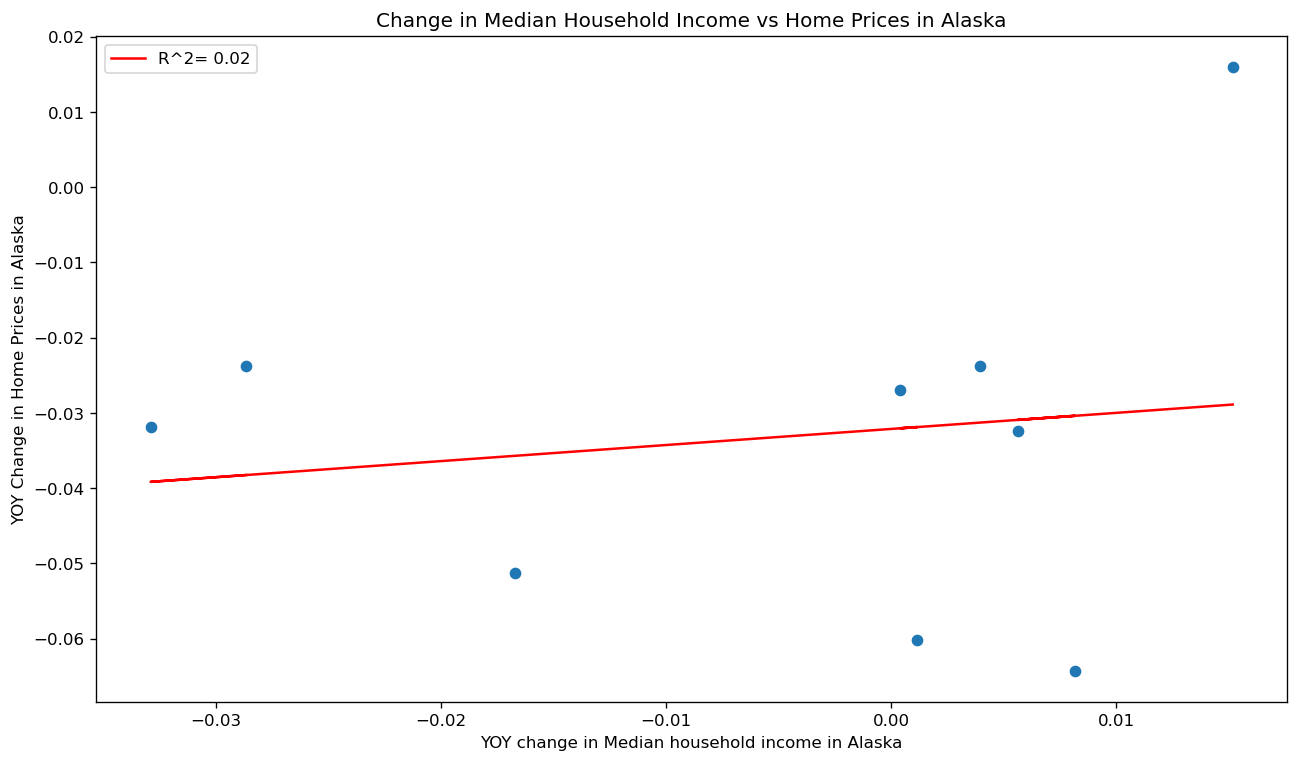

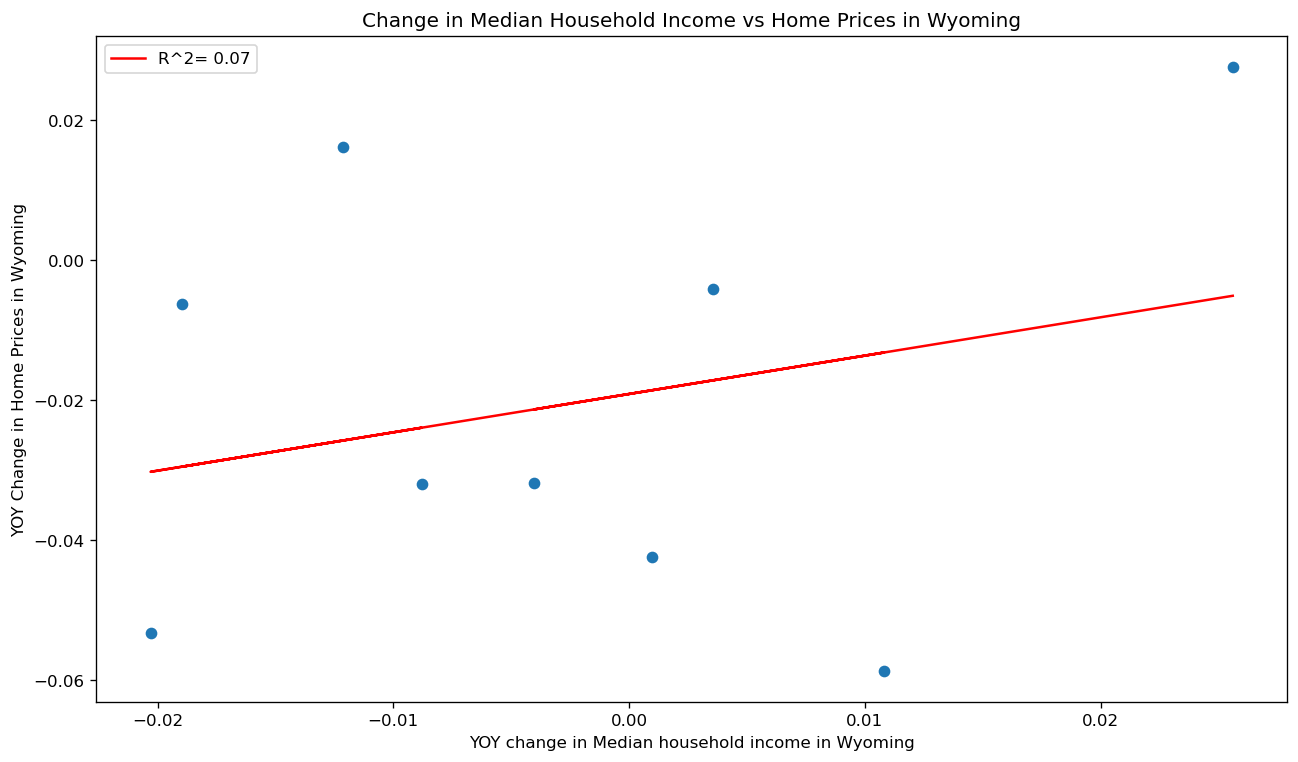

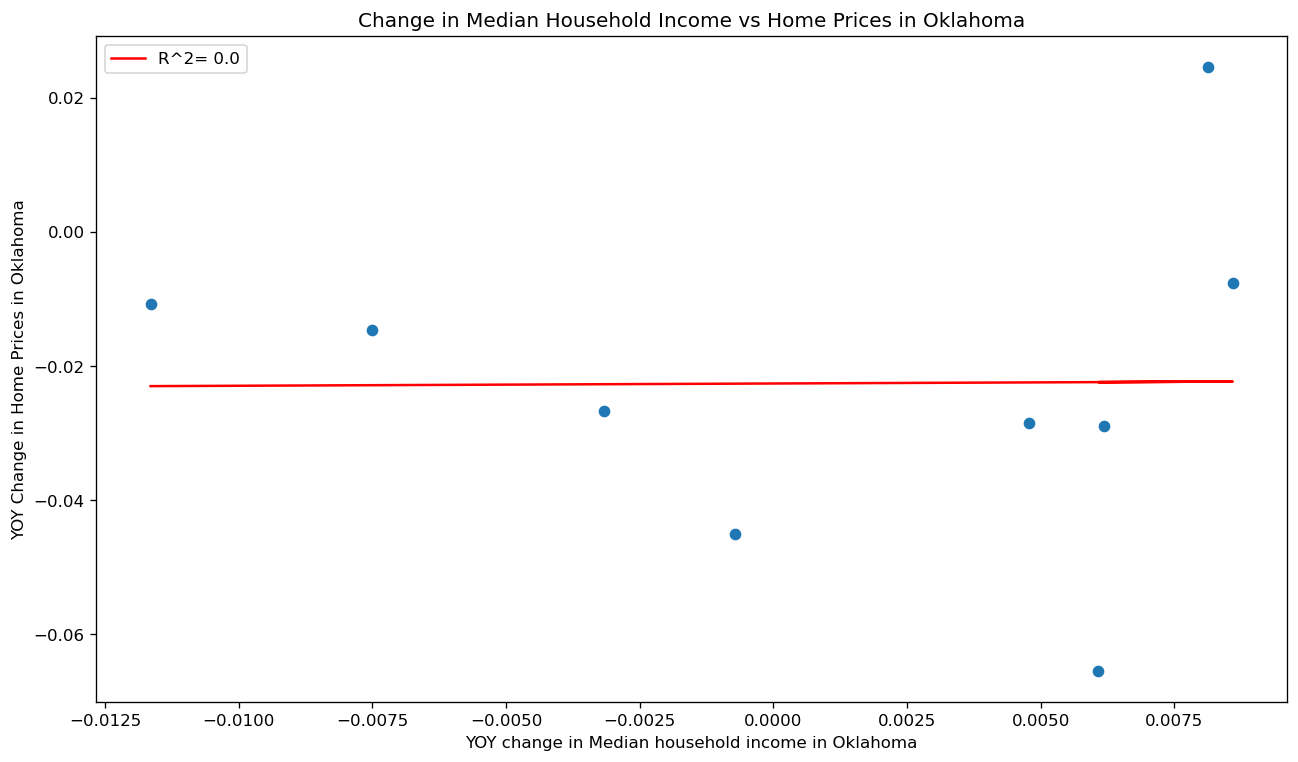

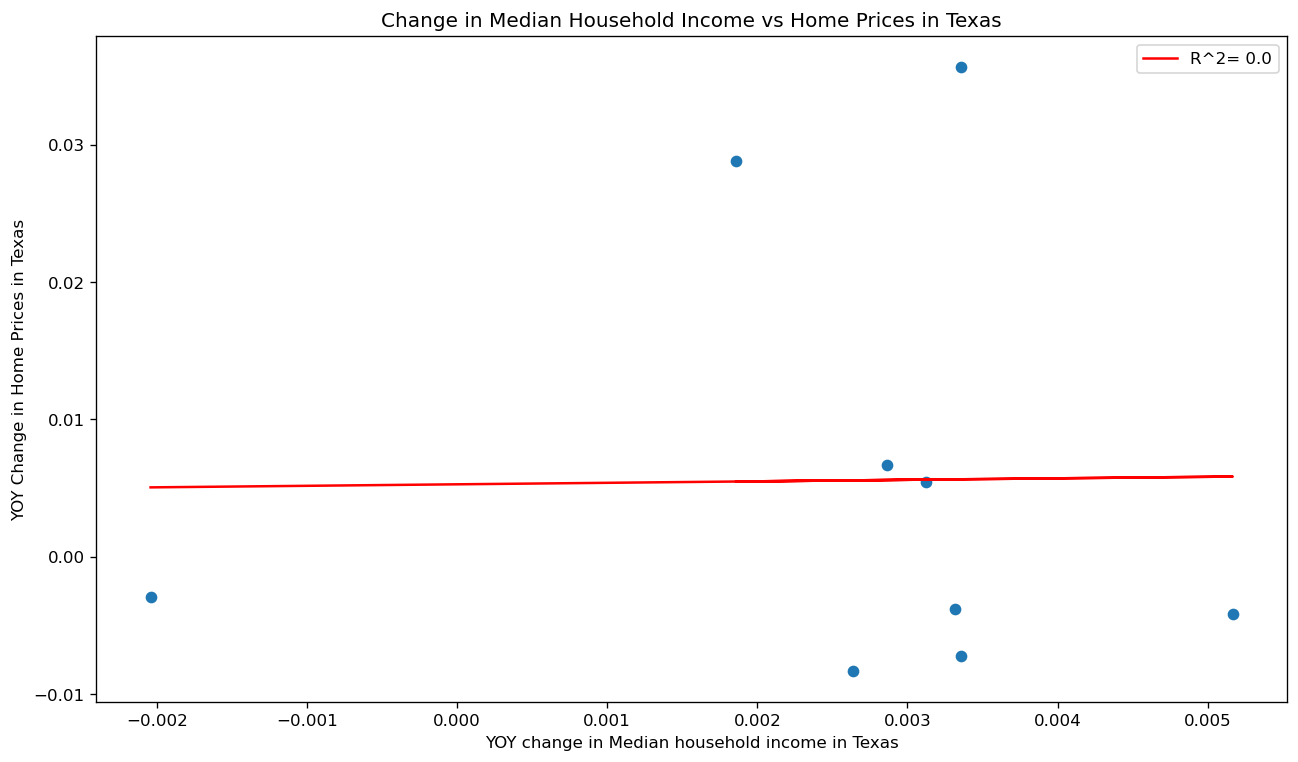

In [24]:
for state in target_states:
    data=acs_by_col[acs_by_col['State']==state]
    x=data['YOY_Change_in_Median_household_income'][1:10]-avg_state_median_income_by_year_YOY[0:9]
    y=housing_data[str(state)+' YOY_change'][7:16]-housing_data['U.S. YOY_change'][7:16]

    x_label=f"YOY change in Median household income in {state}"
    y_label=f"YOY Change in Home Prices in {state}"
    title=f"Change in Median Household Income vs Home Prices in {state}"
    make_regression_graph(x,y,x_label,y_label,title,figsize=[12.8,7.2],dpi=120)

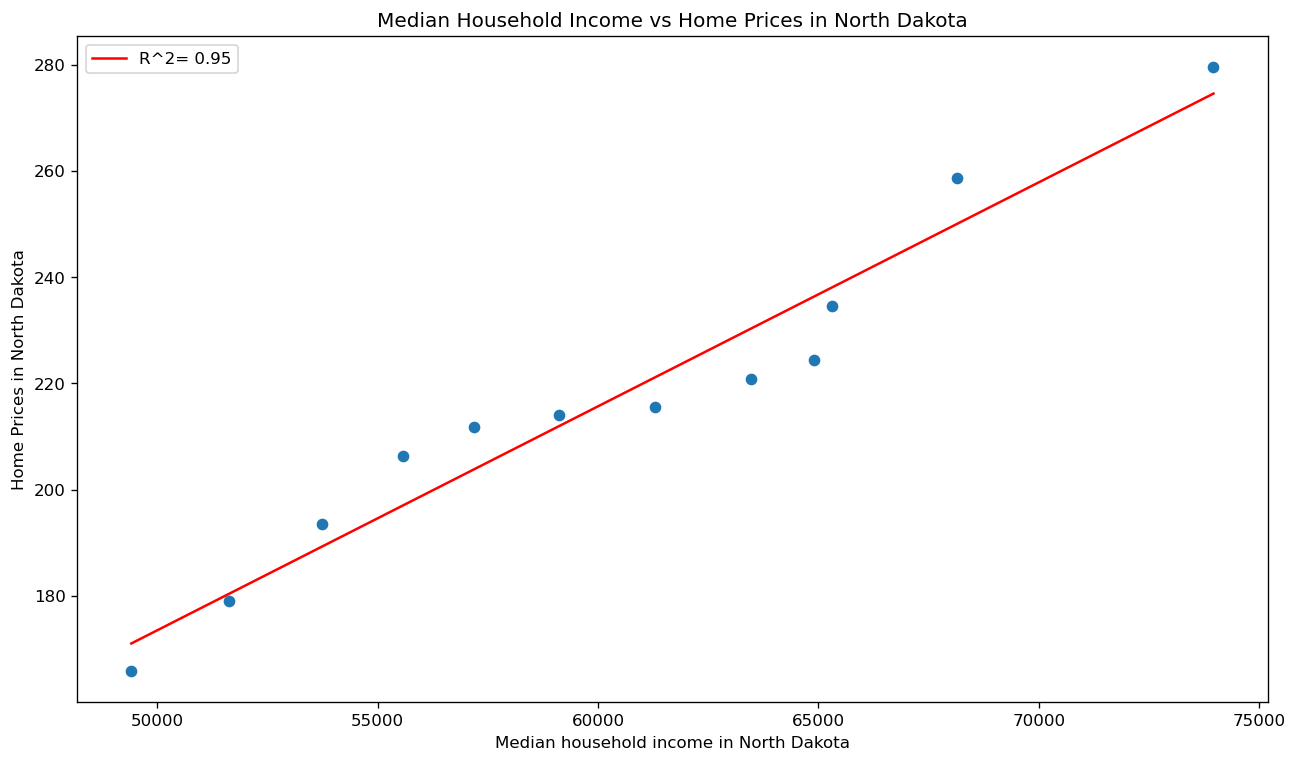

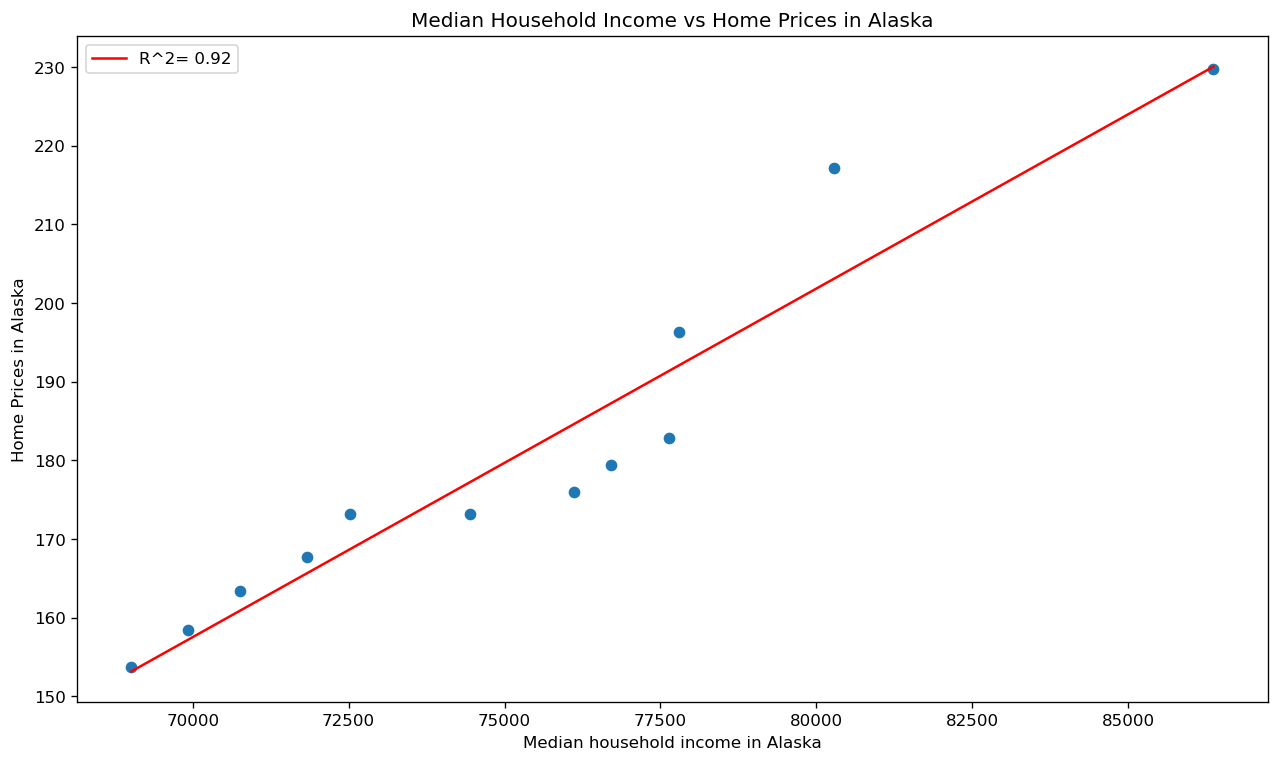

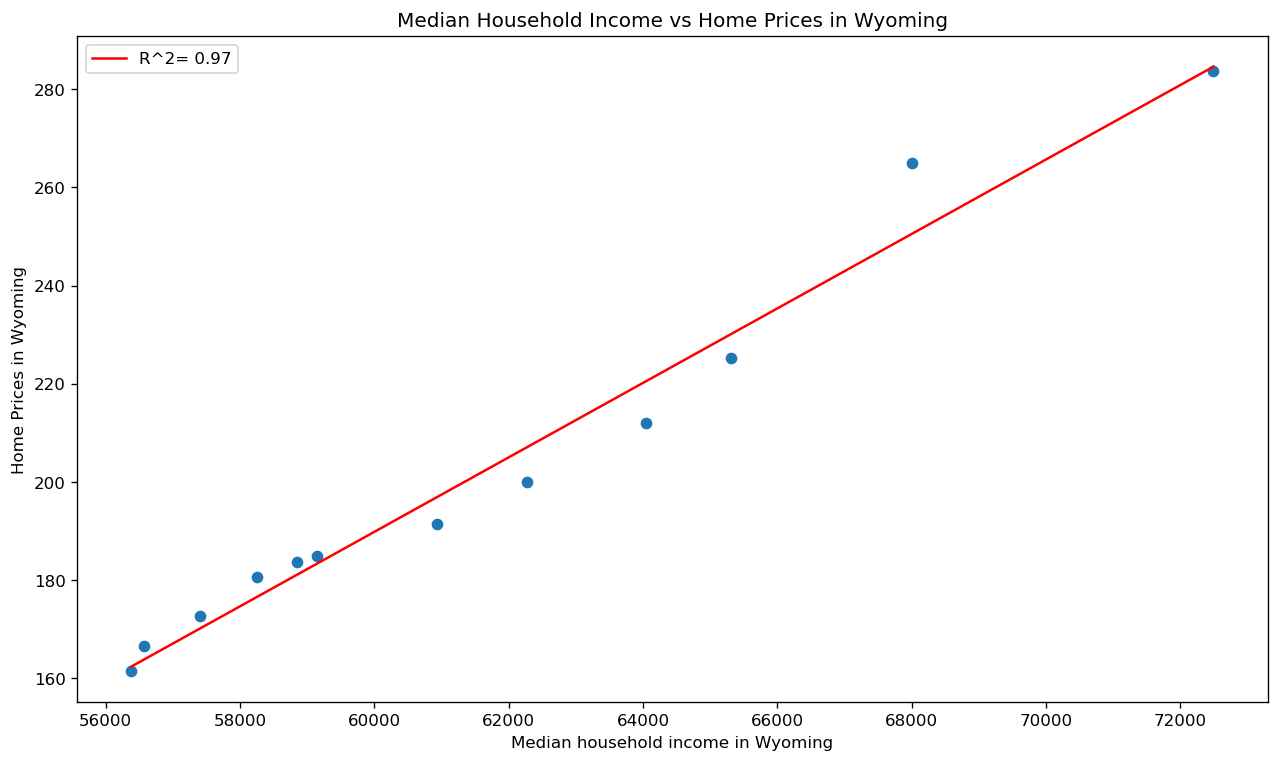

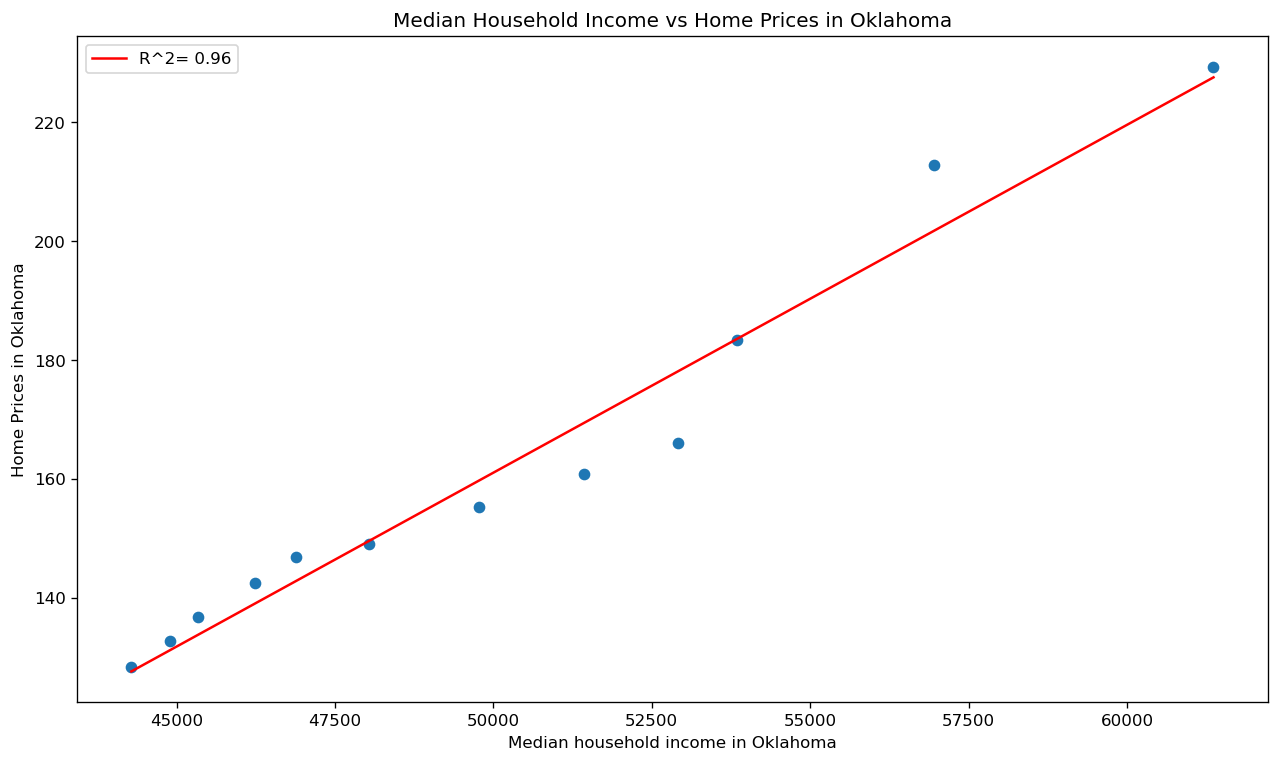

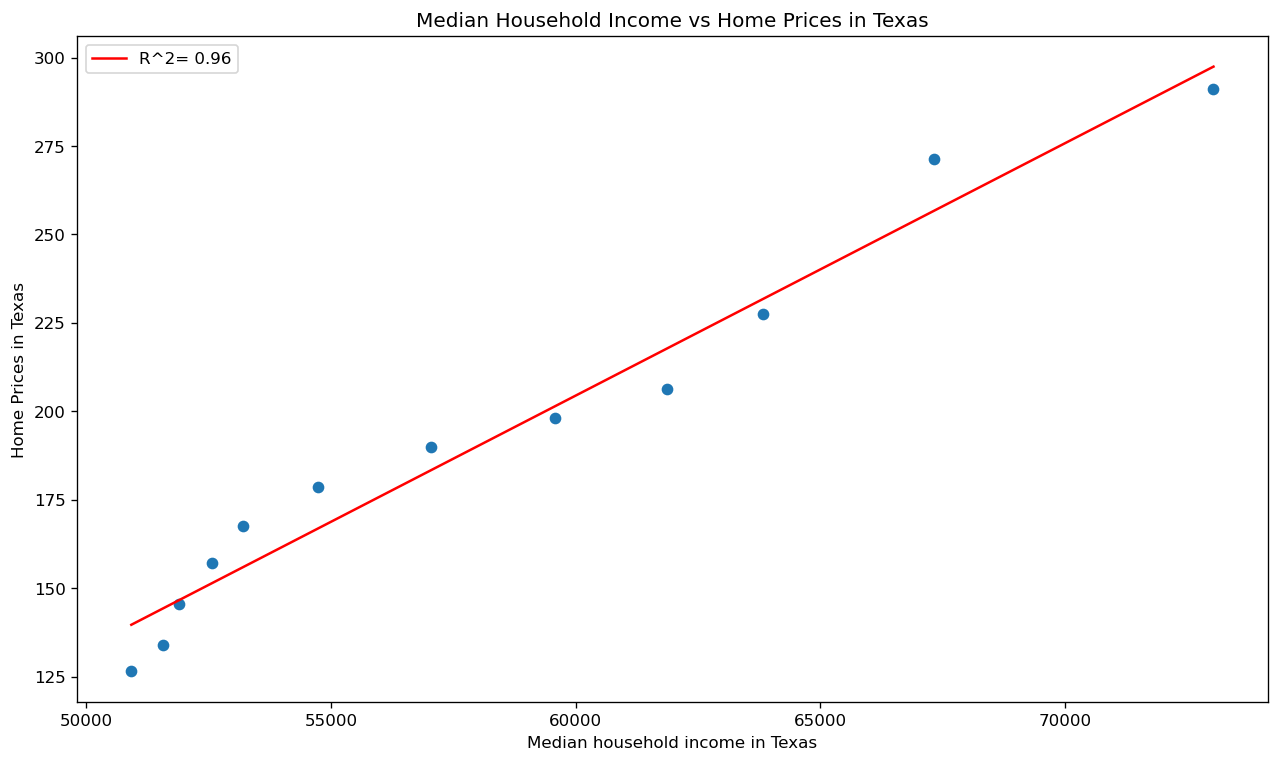

In [25]:
for state in target_states:
    data=acs_by_col[acs_by_col['State']==state]
    x=data['INCOME AND BENEFITS (Not inflation Adjusted)__Median household income (dollars)'][1:13]
    y=housing_data[str(state)][7:19]

    x_label=f"Median household income in {state}"
    y_label=f"Home Prices in {state}"
    title=f"Median Household Income vs Home Prices in {state}"
    make_regression_graph(x,y,x_label,y_label,title,figsize=[12.8,7.2],dpi=120)

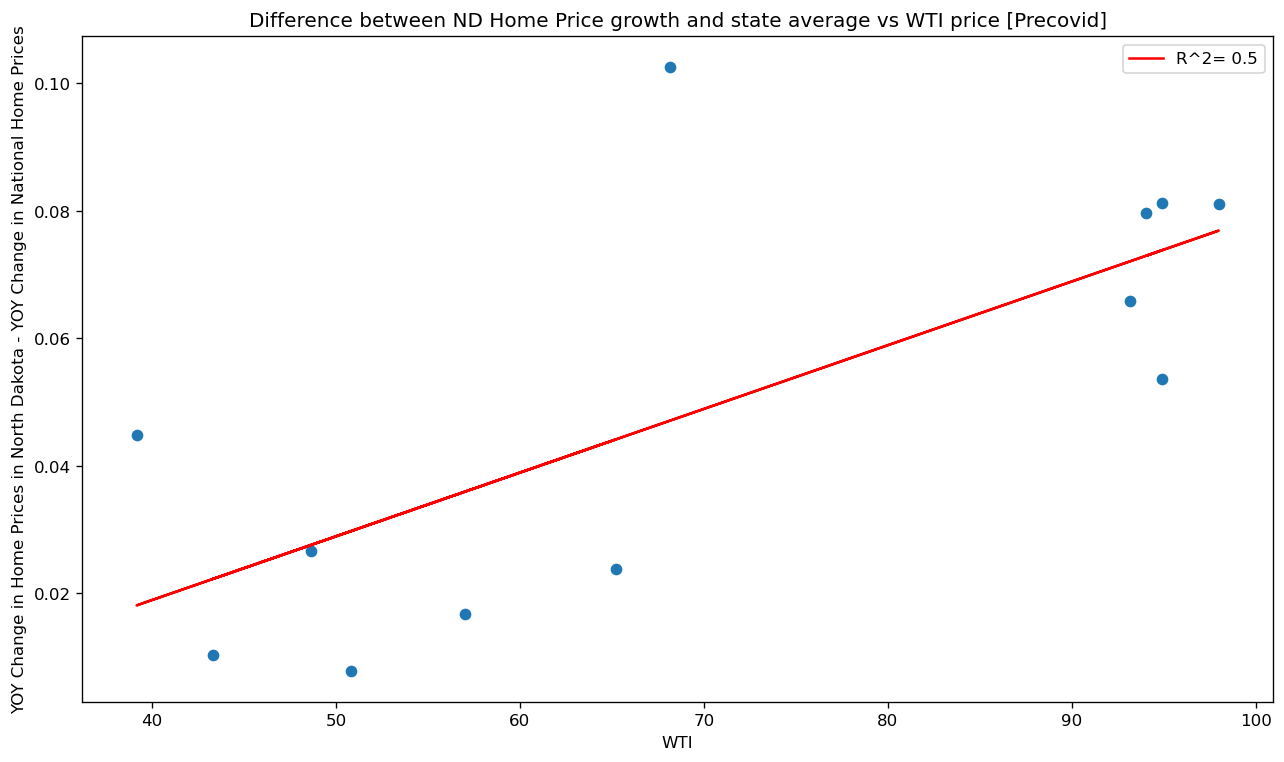

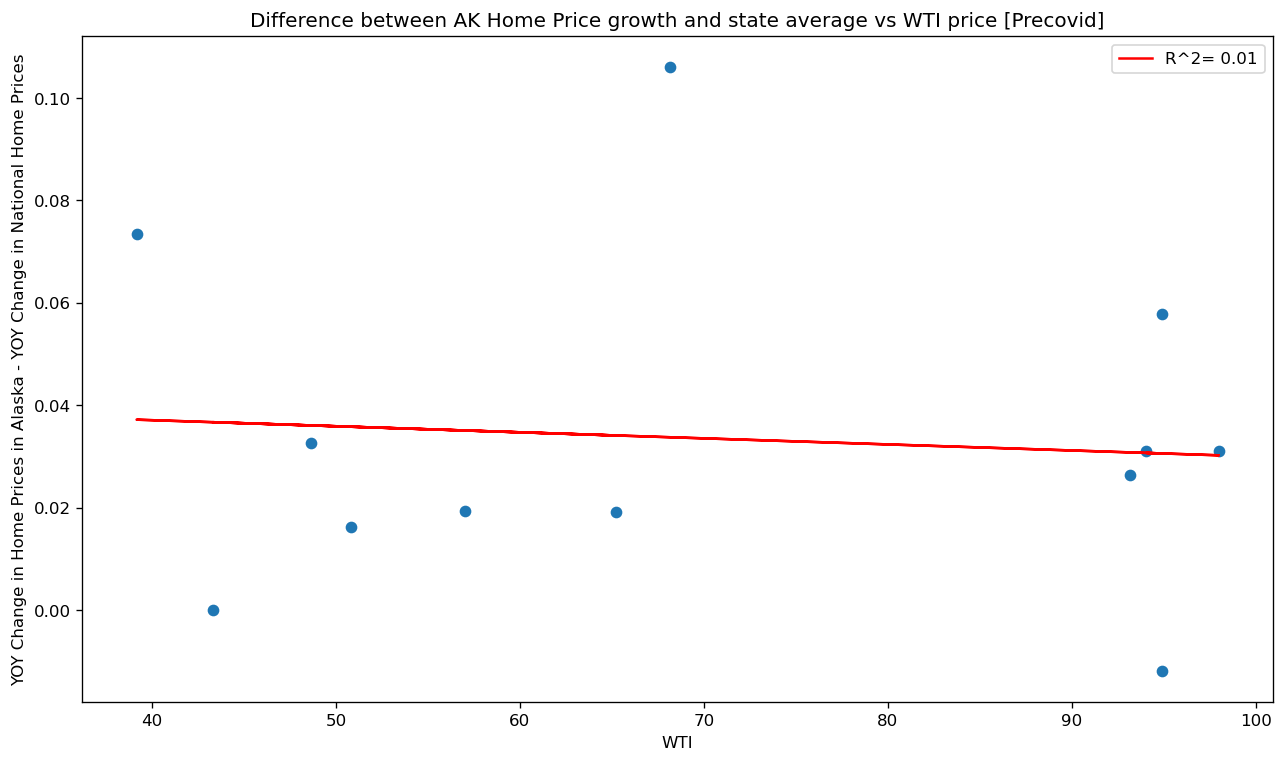

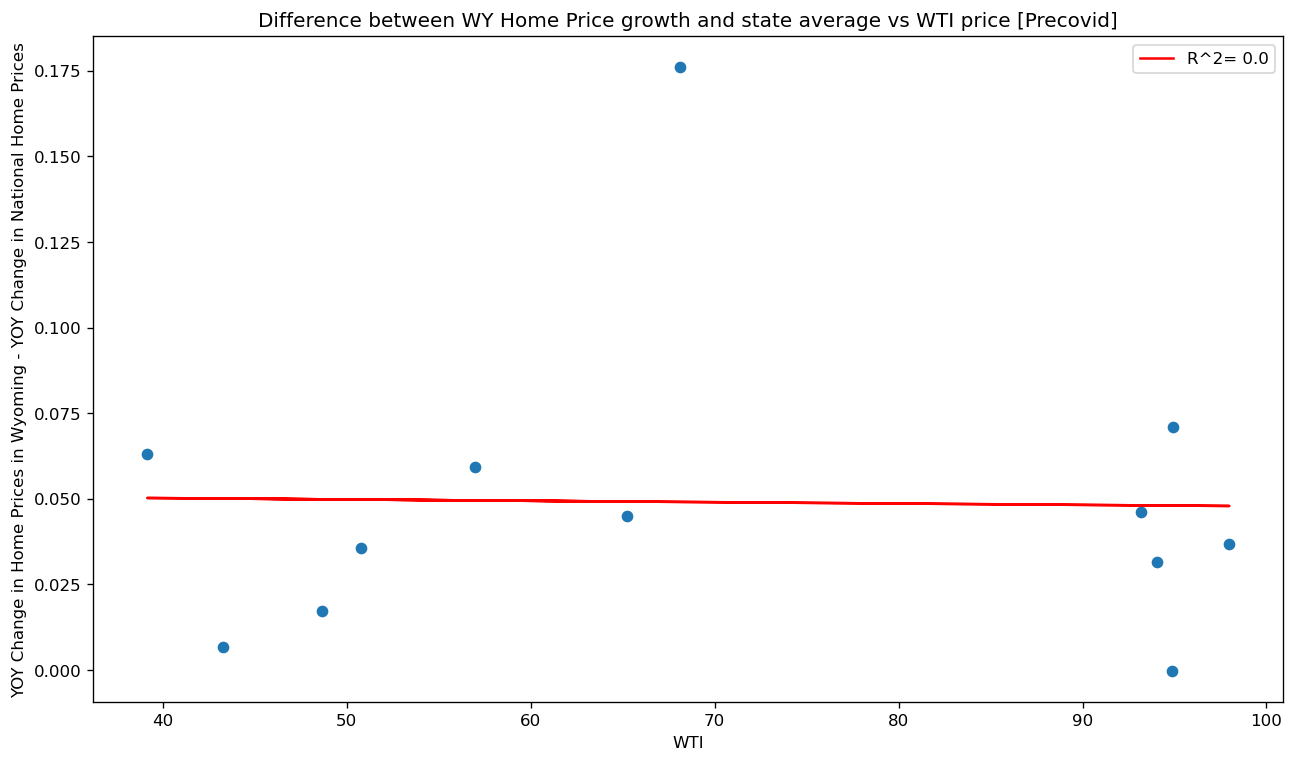

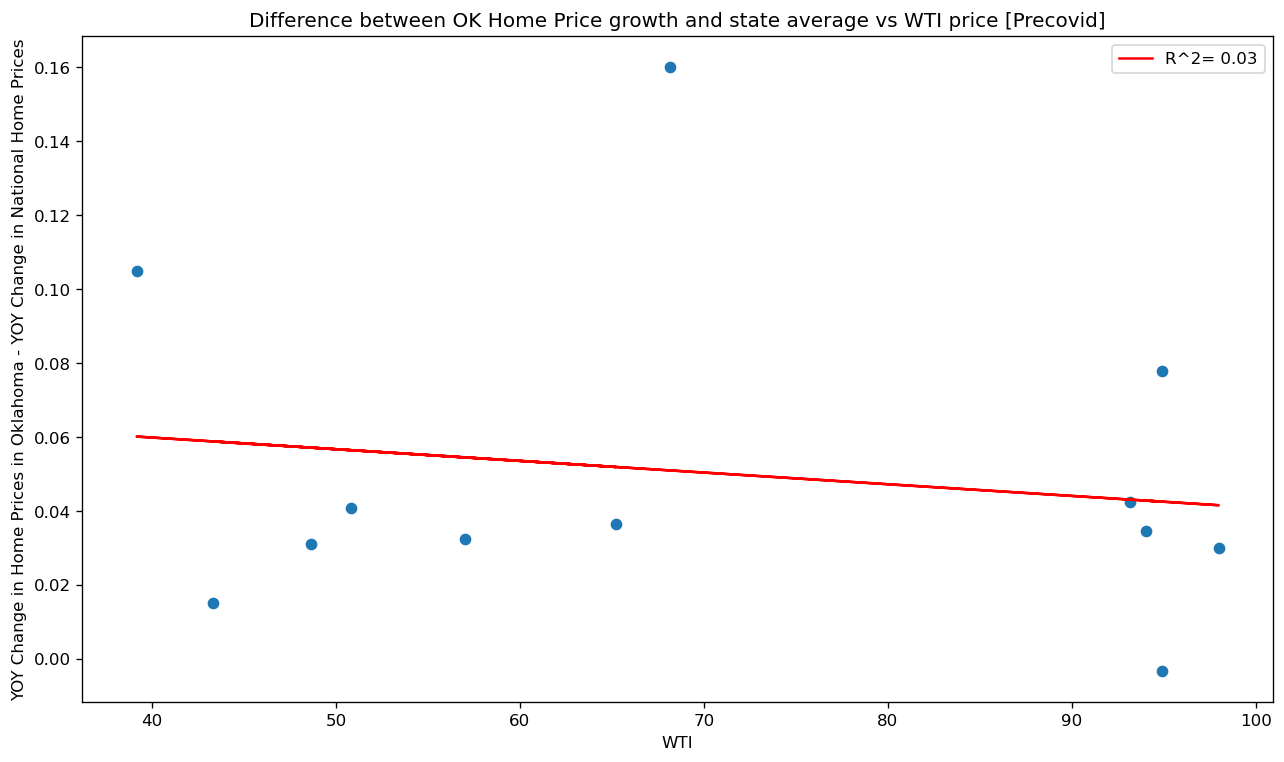

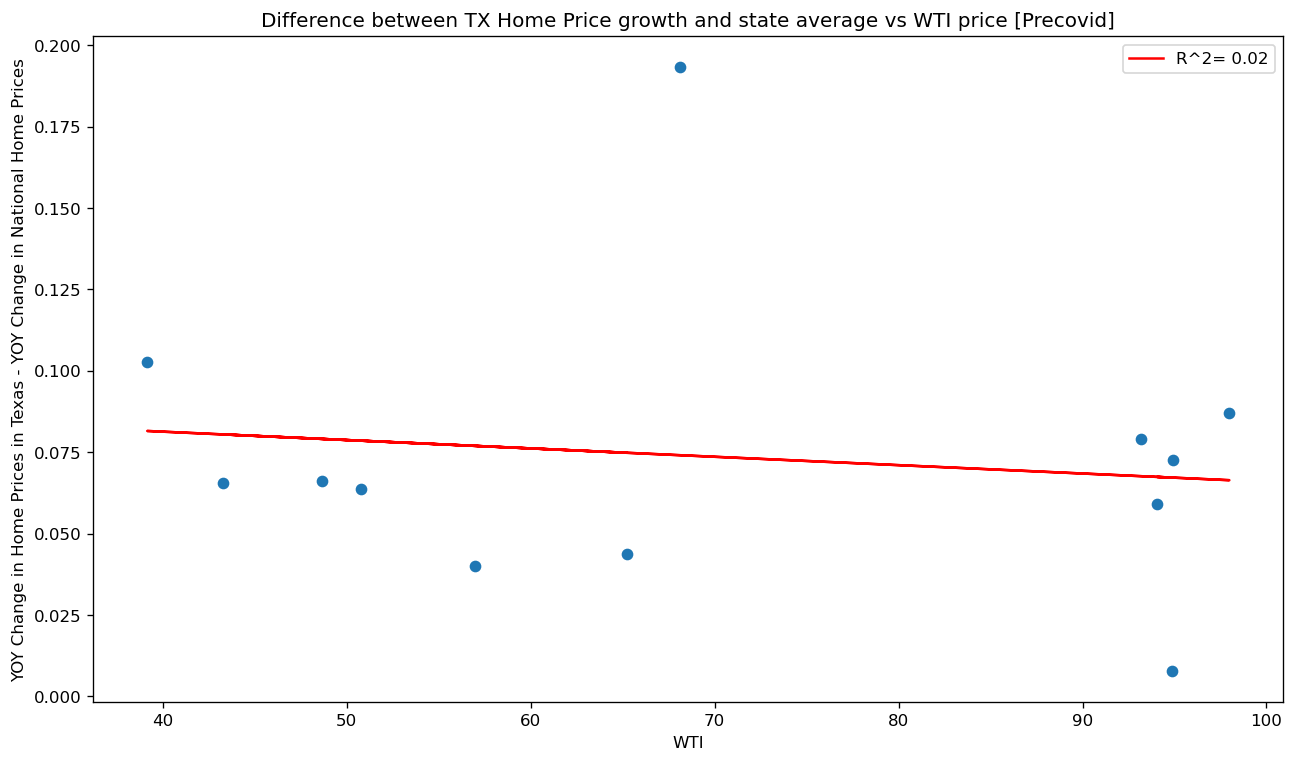

In [26]:
for state in target_states:
    x=np.array(wti_avg_by_year[1:13])   
    y=housing_data[str(state)+' YOY_change'][7:19]

    x_label=f"WTI"
    y_label=f"YOY Change in Home Prices in {state} - YOY Change in National Home Prices"
    title=f"Difference between {state_abbreviations[state]} Home Price growth and state average vs WTI price [Precovid]"
    make_regression_graph(x,y,x_label,y_label,title,figsize=[12.8,7.2],dpi=120)


In [29]:
#convert to numeric 
acs_by_col.loc[:,'EMPLOYMENT STATUS_Population 16 years and over_In labor force']=[float(str(i).replace('%','')) for i in acs_by_col.loc[:,'EMPLOYMENT STATUS_Population 16 years and over_In labor force']]
avg_employement_by_year=np.array([ acs_by_col[(acs_by_col['Year']==year)]['EMPLOYMENT STATUS_Population 16 years and over_In labor force'].mean() for year in range(2010,2023)])
avg_employement_by_year

array([65.39230769, 65.22307692, 65.05576923, 64.61730769, 64.25384615,
       63.98846154, 63.78653846, 63.66153846, 63.55769231, 63.55192308,
       63.49615385, 63.55576923, 63.41923077])

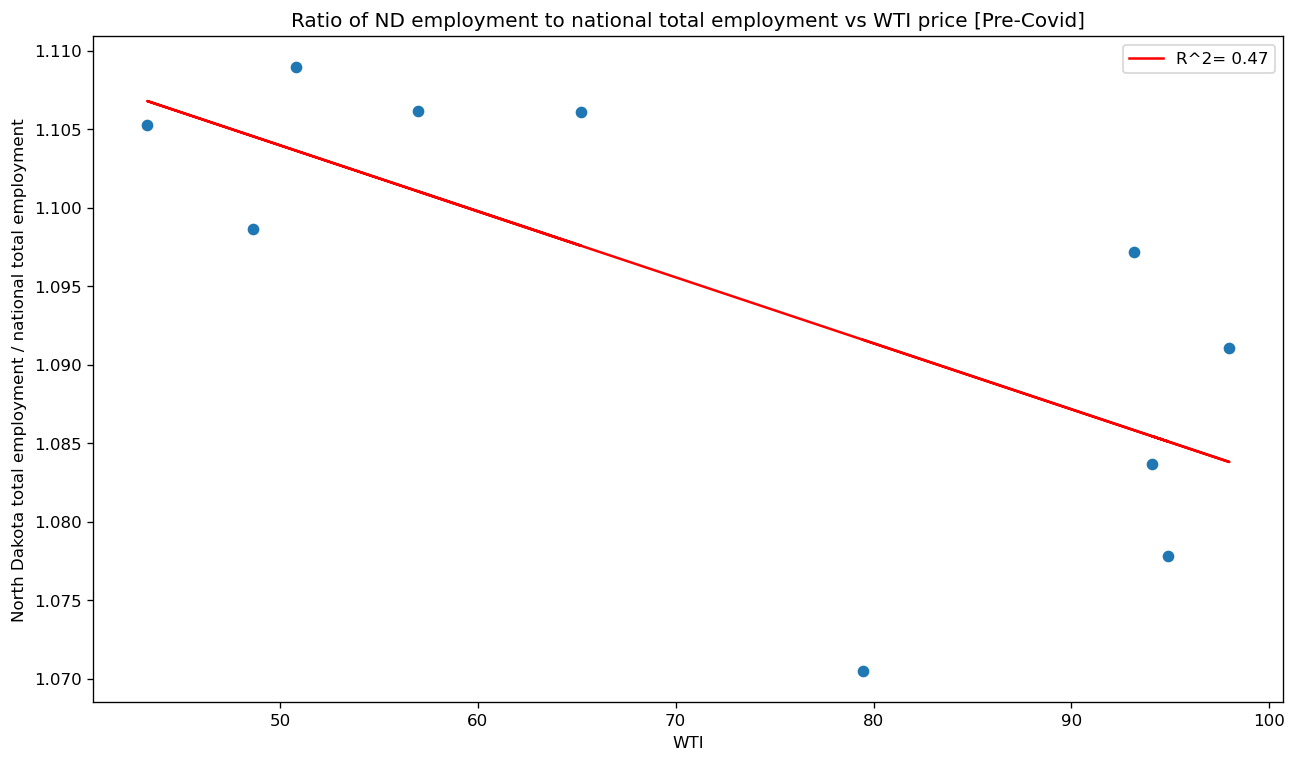

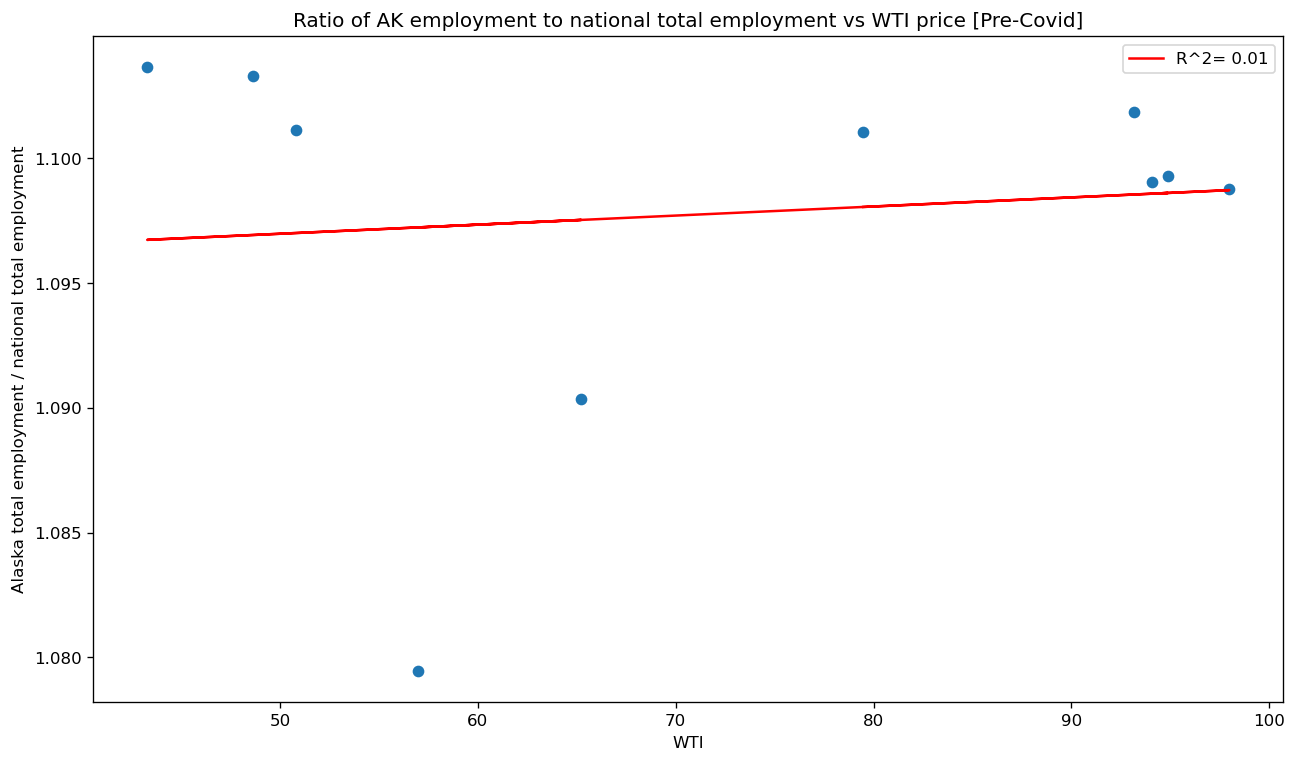

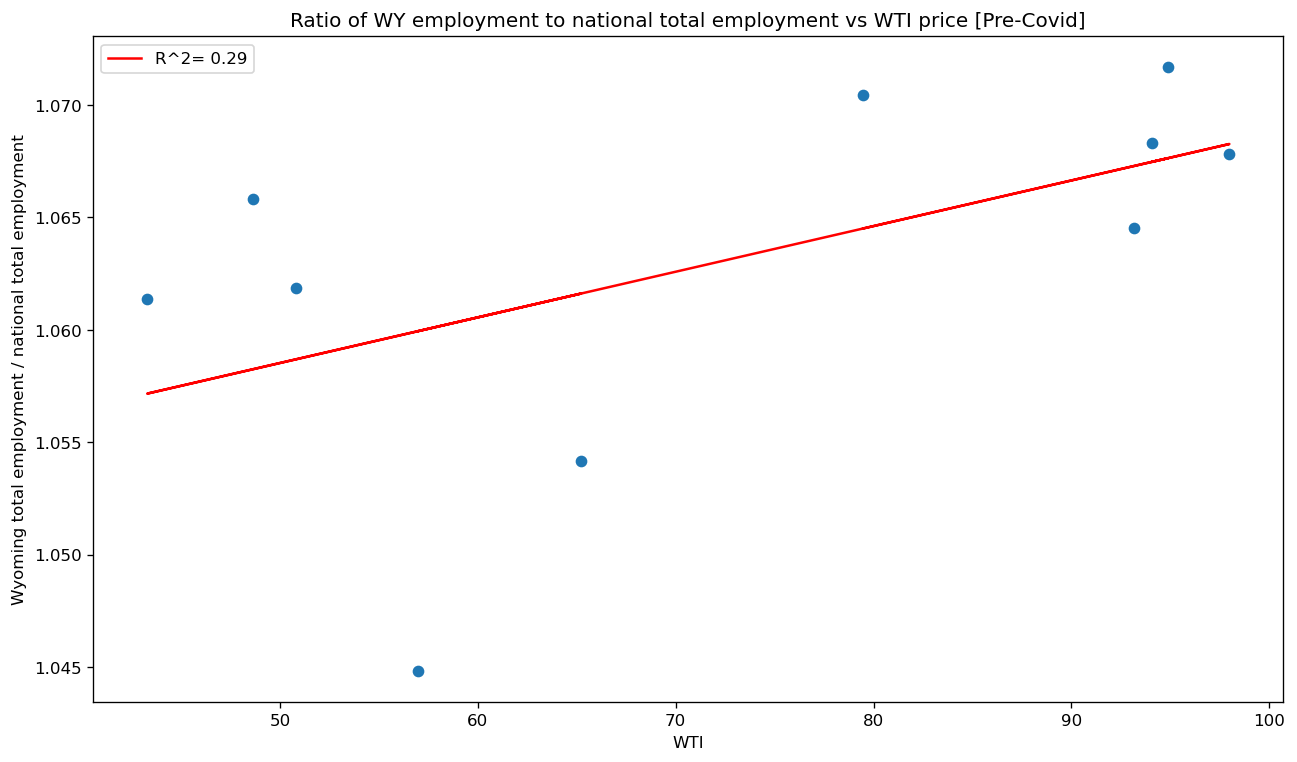

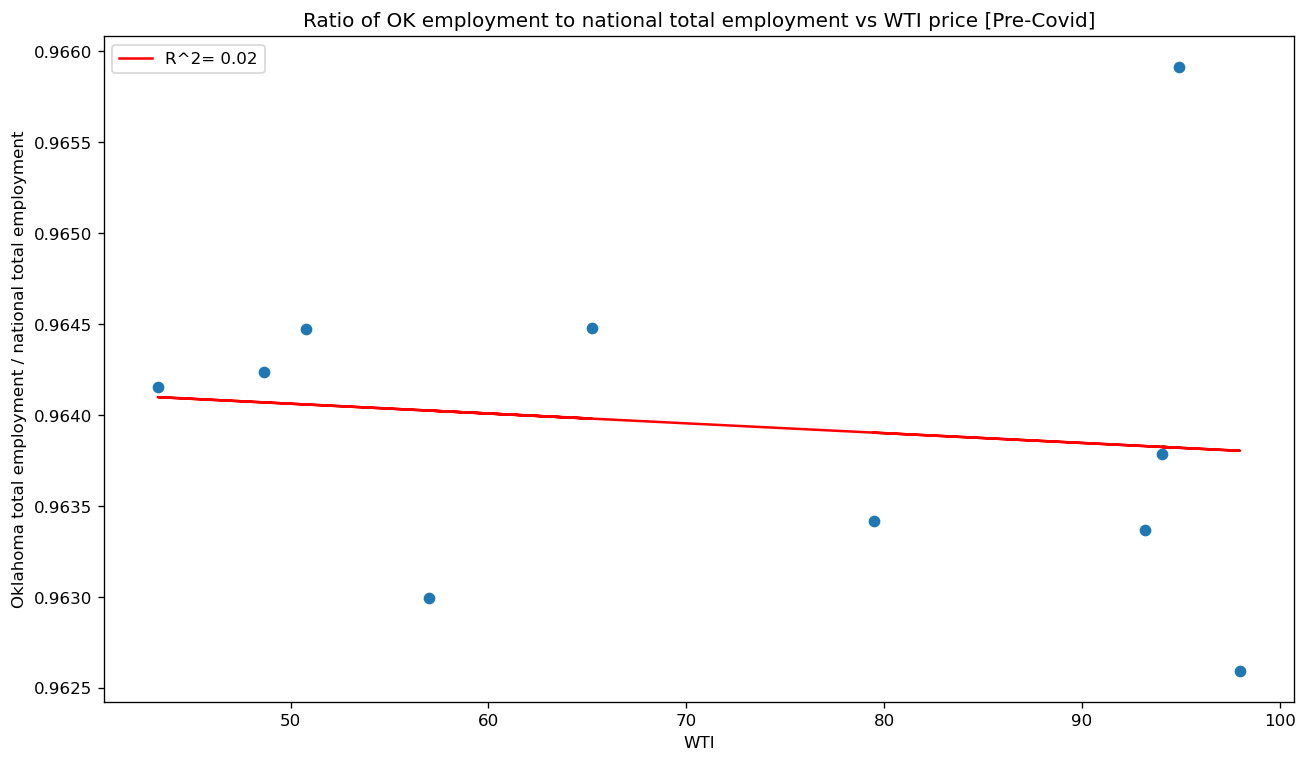

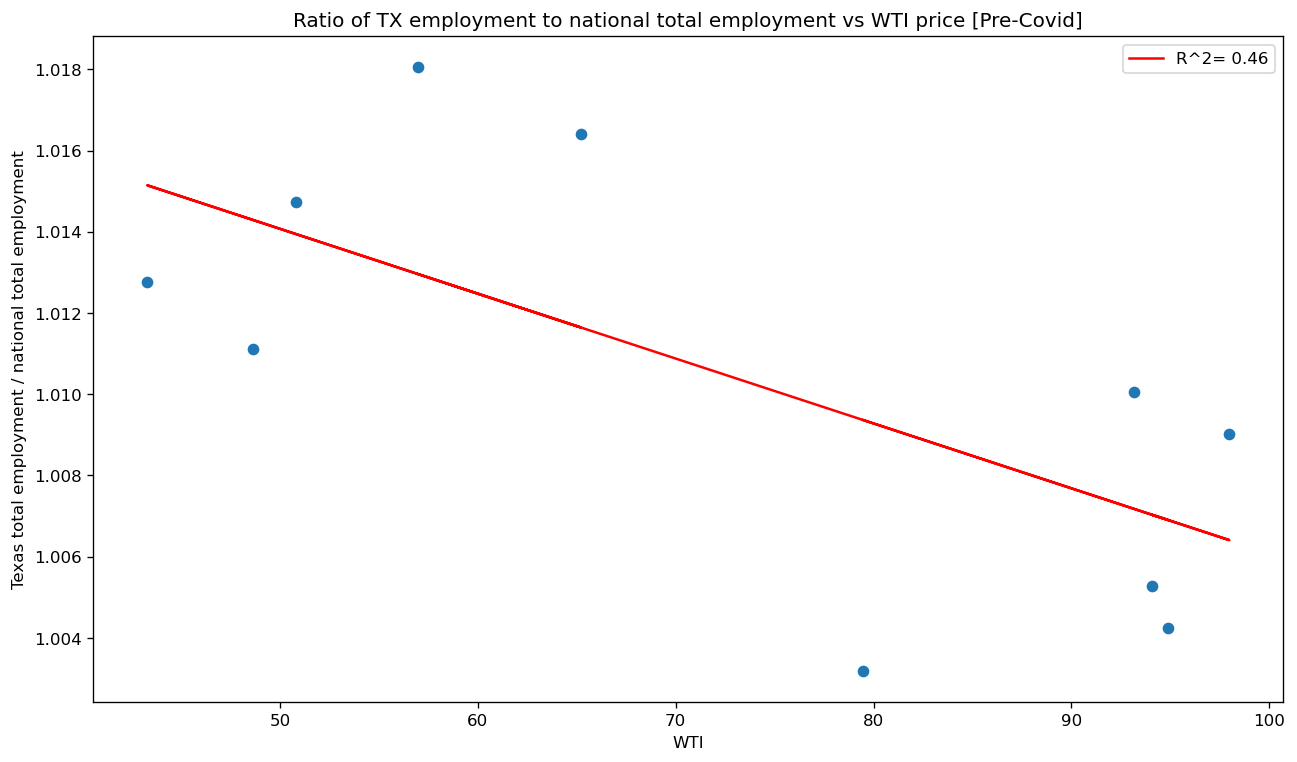

In [33]:
for state in target_states:
    data=acs_by_col[acs_by_col['State']==state]
    y=data['EMPLOYMENT STATUS_Population 16 years and over_In labor force'][0:10]/avg_employement_by_year[0:10]
    x=np.array(wti_avg_by_year[0:10])
    x_label='WTI'
    y_label=f"{state} total employment / national total employment"
    title=f"Ratio of {state_abbreviations[state]} employment to national total employment vs WTI price [Pre-Covid]"
    make_regression_graph(x,y,x_label,y_label,title,figsize=[12.8,7.2],dpi=120)

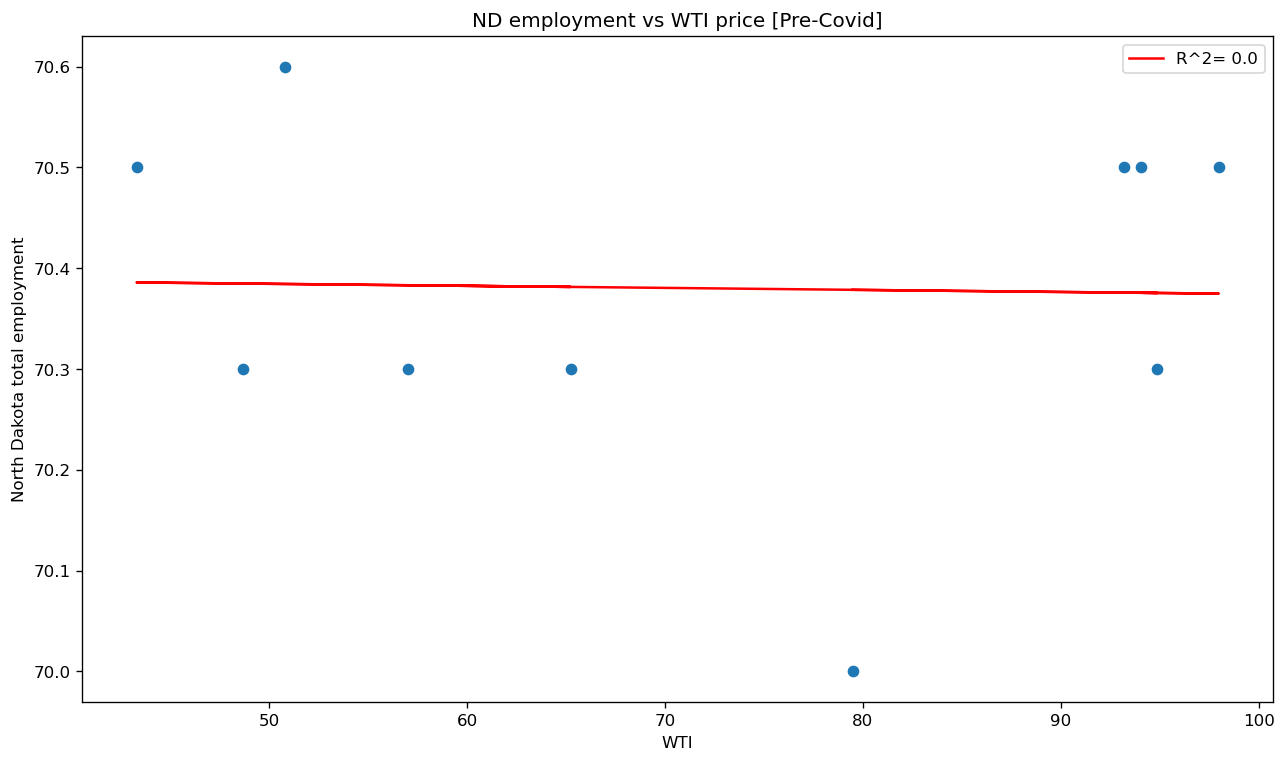

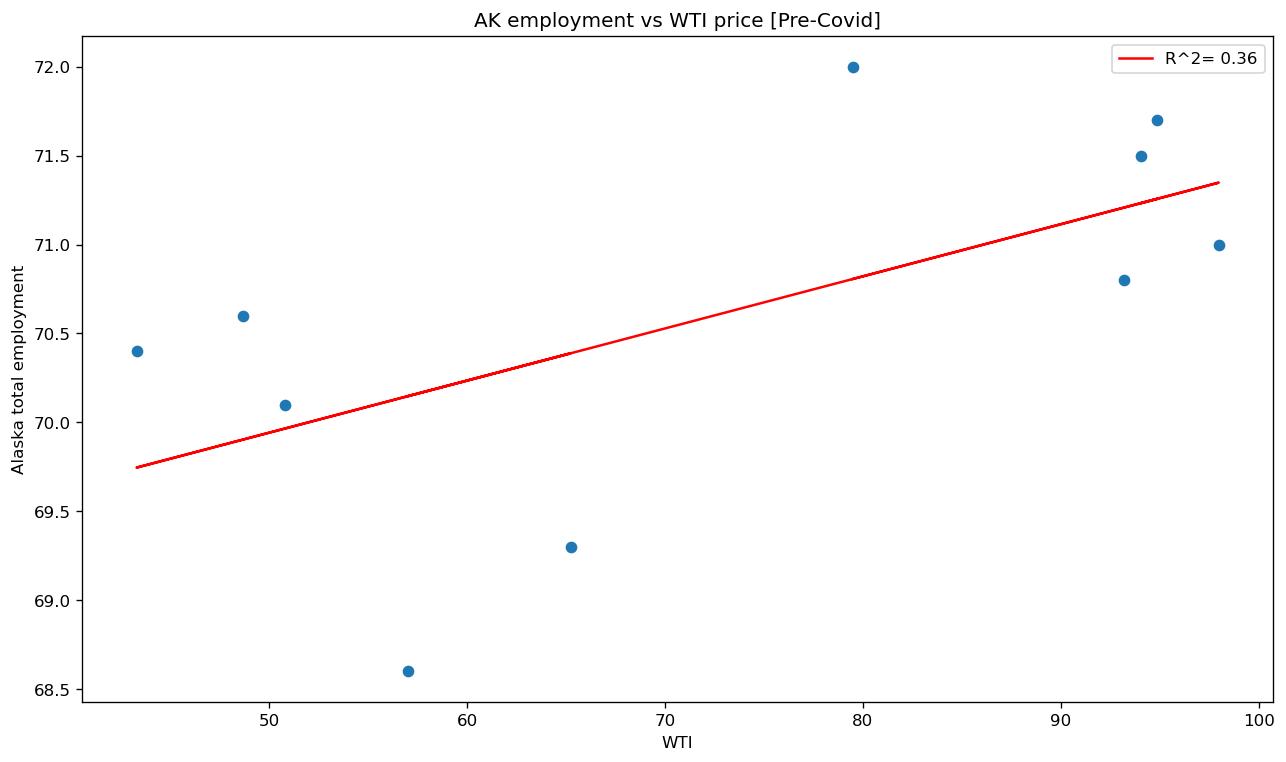

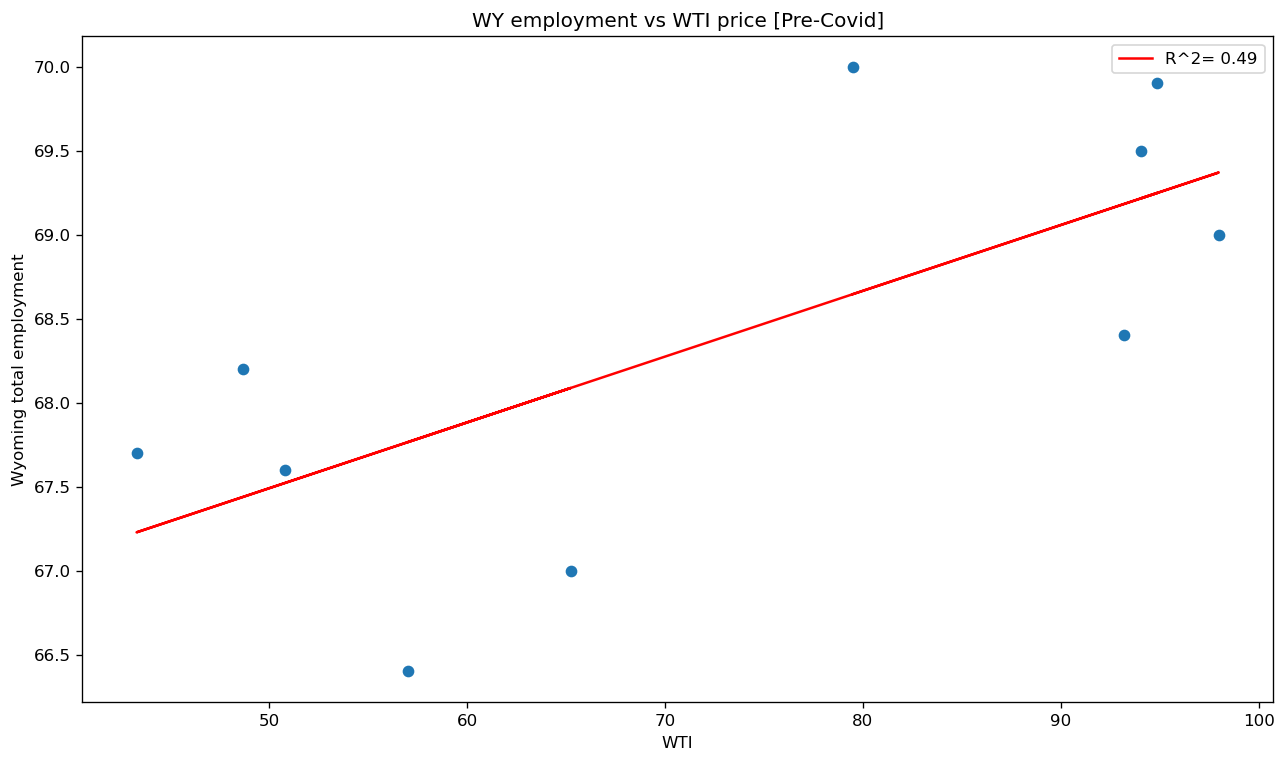

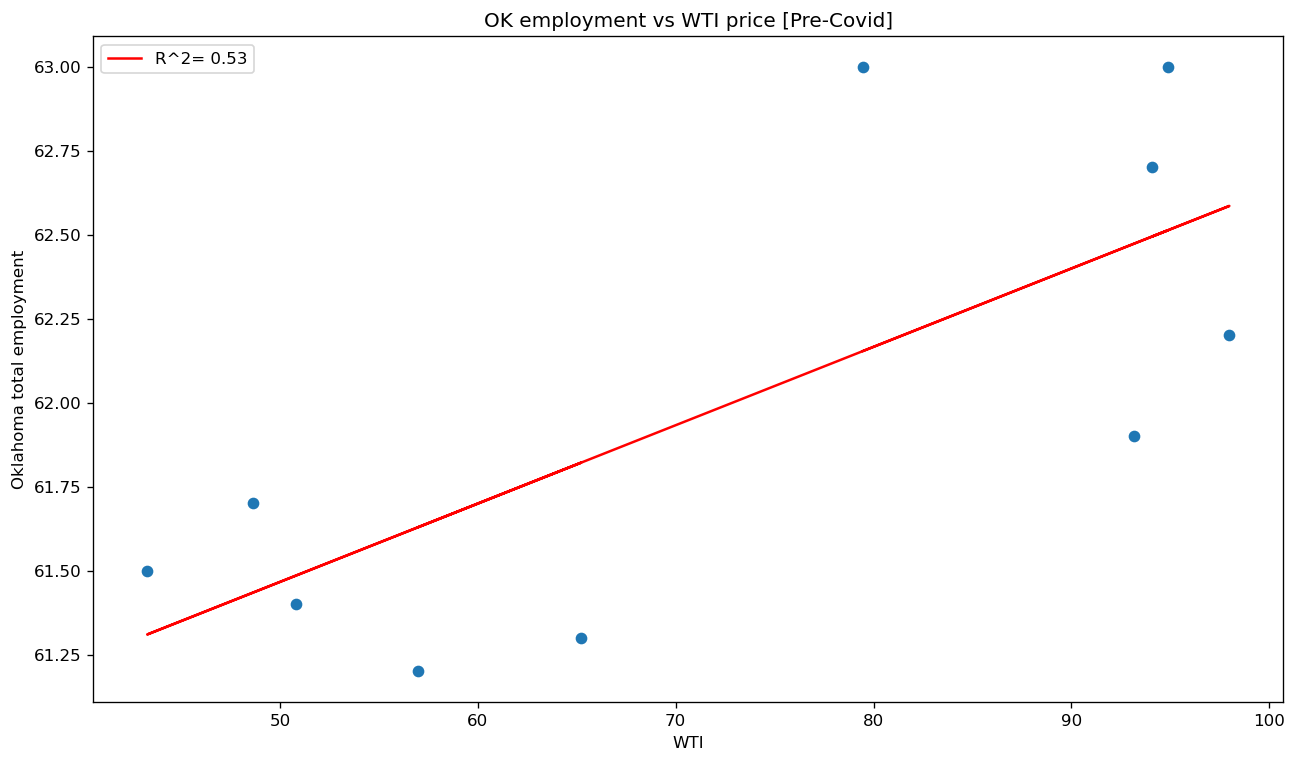

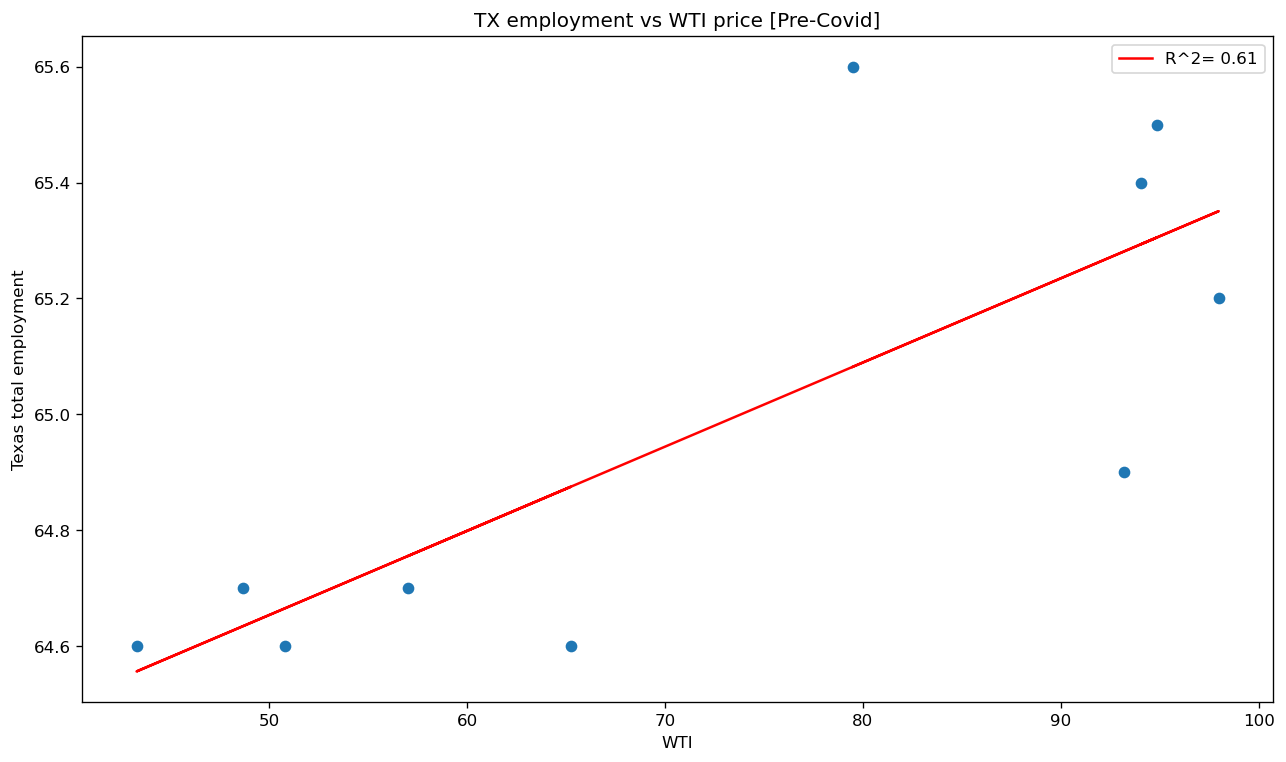

In [35]:
for state in target_states:
    data=acs_by_col[acs_by_col['State']==state]
    y=data['EMPLOYMENT STATUS_Population 16 years and over_In labor force'][0:10]
    x=np.array(wti_avg_by_year)[0:10]
    x_label='WTI'
    y_label=f"{state} total employment"
    title=f"{state_abbreviations[state]} employment vs WTI price [Pre-Covid]"
    make_regression_graph(x,y,x_label,y_label,title,figsize=[12.8,7.2],dpi=120)

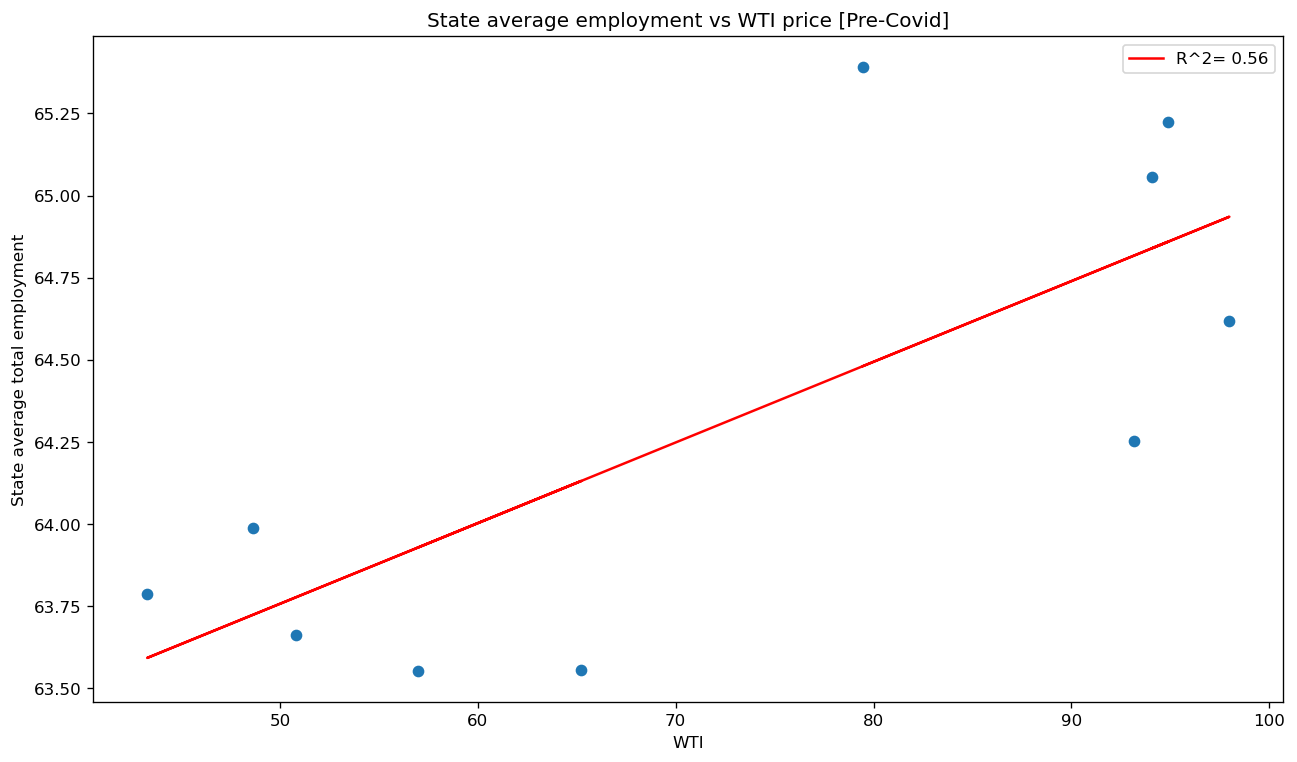

In [39]:
y=avg_employement_by_year[0:10]
x=np.array(wti_avg_by_year)[0:10]
x_label='WTI'
y_label=f"State average total employment"
title=f"State average employment vs WTI price [Pre-Covid]"
make_regression_graph(x,y,x_label,y_label,title,figsize=[12.8,7.2],dpi=120)

In [47]:
def get_corr(state):
    data=acs_by_col[acs_by_col['State']==state]
    y=data['YOY_Change_in_Median_household_income'][1:10]-avg_state_median_income_by_year_YOY[0:9]
    x=np.array(wti_avg_by_year[1:10])
    model=LinearRegression()
    model.fit(X=np.array(x).reshape(-1, 1),y=y)
    r_sq=round(model.score(X=np.array(x).reshape(-1, 1),y=y),2)
    #gets r^2 (excess state income growth,wti prices)
    return(r_sq)

In [51]:
get_corr('Louisiana')

0.46

In [ ]:
data=acs_by_col[acs_by_col['State']=='Wyoming']
y=data['YOY_Change_in_Median_household_income'][1:10]-avg_state_median_income_by_year_YOY[0:9]
x=np.array(wti_avg_by_year[1:10])
fig = plt.figure(figsize=[12.8,7.2],dpi=120)
ax1 = fig.add_subplot(111)
ax1.set_title('Difference between WY income growth and state average vs WTI price precovid')
ax1.set_ylabel('Difference between Wyoming YOY growth and mean of all States')
ax1.set_xlabel('WTI')
ax1.scatter(x=x,y=y)
model=LinearRegression()
model.fit(X=np.array(x).reshape(-1, 1),y=y)
slope,intercept=model.coef_[0],model.intercept_
r_sq=round(model.score(X=np.array(x).reshape(-1, 1),y=y),2)
ax1.plot(x, intercept + slope*x, 'r', label='R^2= '+str(r_sq))
plt.legend()
plt.show()

In [ ]:
y=np.array(avg_state_median_income_by_year_YOY[0:9])
x=np.array(wti_avg_by_year[1:10])
fig = plt.figure(figsize=[12.8,7.2],dpi=120)
ax1 = fig.add_subplot(111)
ax1.set_title('state average income growth vs WTI price precovid')
ax1.set_xlabel('WTI')
ax1.set_ylabel('Median Household income growth YOY')
ax1.scatter(x=x,y=y)
model=LinearRegression()
model.fit(X=np.array(x).reshape(-1, 1),y=y)
r_sq=round(model.score(X=np.array(x).reshape(-1, 1),y=y),2)
slope,intercept=model.coef_[0],model.intercept_
ax1.plot(x, intercept + slope*x, 'r', label='R^2= '+str(r_sq))
plt.legend()
plt.show()